In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [62]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [63]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop(['summary', 'img_url', 'img_path'], axis = 1, inplace = True)



In [64]:
books['book_title']= books['book_title'].apply(lambda x: ''.join(x.split()).strip())
books['book_title']

0                                               ClaraCallan
1                                        DecisioninNormandy
2         Flu:TheStoryoftheGreatInfluenzaPandemicof1918a...
3                                       TheKitchenGod'sWife
4         WhatIf?:TheWorld'sForemostMilitaryHistoriansIm...
                                ...                        
149565    TheBachelorHomeCompanion:APracticalGuidetoKeep...
149566    AllElevationsUnknown:AnAdventureintheHeartofBo...
149567      Whystop?:AguidetoTexashistoricalroadsidemarkers
149568    TheAreYouBeingServed?Stories:'CampingIn'andOth...
149569         DallasStreetMapGuideandDirectory,2000Edition
Name: book_title, Length: 149570, dtype: object

In [65]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [66]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [67]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [68]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     68092 non-null  int64  
 4   location_state    68092 non-null  int64  
 5   location_country  68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [69]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [70]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


## rating 테이블과 merge

In [71]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')


In [72]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 315083
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           306795 non-null  object 
 1   isbn              306795 non-null  object 
 2   rating            306795 non-null  float64
 3   book_title        306795 non-null  object 
 4   book_author       306795 non-null  object 
 5   publisher         306795 non-null  object 
 6   language          306795 non-null  object 
 7   category_high     306795 non-null  object 
 8   years             306795 non-null  object 
 9   location_city     306795 non-null  object 
 10  location_state    306795 non-null  object 
 11  location_country  306795 non-null  object 
 12  fix_age           306795 non-null  object 
dtypes: float64(1), object(12)
memory usage: 32.8+ MB


In [73]:
train_ratings

,user_id,isbn,rating,book_title,book_author,publisher,language,category_high,years,location_city,location_state,location_country,fix_age
0,8.0,0002005018,4.0,ClaraCallan,Richard Bruce Wright,HarperFlamingo Canada,en,actresses,2020.0,0,0,0,10.0
1,8.0,074322678X,4.0,WhereYou'llFindMe:AndOtherStories,Ann Beattie,Scribner,en,fiction,2020.0,0,0,0,10.0
2,8.0,0887841740,2.0,TheMiddleStories,Sheila Heti,House of Anansi Press,en,fiction,2020.0,0,0,0,10.0
3,8.0,1552041778,2.0,JaneDoe,R. J. Kaiser,Mira Books,en,fiction,2000.0,0,0,0,10.0
4,8.0,1567407781,6.0,TheWitchfinder(AmosWalkerMysterySeries),Loren D. Estleman,Brilliance Audio - Trade,en,fiction,2000.0,0,0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315079,278376.0,0060530103,7.0,TheGrandmothers:FourShortNovels,Doris Lessing,HarperCollins,en,fiction,2020.0,1127,8,2,100.0
315080,278621.0,1550390961,8.0,"GileanDouglas:WritingNature,FindingHome",Andrea Pinto Lebowitz,Sono Nis Press,en,authors canadian english 20th century biography,2000.0,4,83,0,100.0
315081,278636.0,0375507299,2.0,TheSnowGeese:AStoryofHome,William Fiennes,Random House,en,fiction,2020.0,9329,39,2,10.0
315082,278659.0,0345330293,10.0,TownLikeAlice,Nevil Shute,Ballantine Books,en,fiction,1990.0,44,2,0,35.0


In [74]:
type(train_ratings['publisher'][0])

str

# 모델링

In [75]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
folds = []
for train_idx, valid_idx in skf.split(train_ratings, train_ratings['rating']):
  folds.append((train_idx,valid_idx))

In [76]:
cat_models={}

cat_features = list(range(1, 10))

def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    cat_pred = model.predict(X_valid)
    log_score = rmse(y_valid, cat_pred)

    return log_score

for fold in range(0,10):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train_ratings.drop(['rating'],axis = 1).iloc[train_idx]
    X_valid = train_ratings.drop(['rating'],axis = 1).iloc[valid_idx]
    y_train = train_ratings['rating'].iloc[train_idx]
    y_valid = train_ratings['rating'].iloc[valid_idx]

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)


    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', 
                              devices = '0', random_state = SEED, objective = 'RMSE', 
                              cat_features = list(train_ratings.drop(['rating'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================1============================================


[I 2022-11-02 15:19:18,611] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327164	test: 2.4326488	best: 2.4326488 (0)	total: 17.5ms	remaining: 2m 12s
100:	learn: 2.4273628	test: 2.4257219	best: 2.4257219 (100)	total: 1.61s	remaining: 1m 59s
200:	learn: 2.4273615	test: 2.4257040	best: 2.4257040 (199)	total: 3.19s	remaining: 1m 57s
bestTest = 2.425703788
bestIteration = 216
Shrink model to first 217 iterations.


[I 2022-11-02 15:19:27,476] Trial 0 finished with value: 2.425704035595265 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425704035595265.


0:	learn: 2.4330855	test: 2.4330774	best: 2.4330774 (0)	total: 16.4ms	remaining: 2m 19s
100:	learn: 2.4280096	test: 2.4268675	best: 2.4268675 (100)	total: 1.43s	remaining: 1m 58s
200:	learn: 2.4274342	test: 2.4259461	best: 2.4259461 (200)	total: 2.81s	remaining: 1m 56s
300:	learn: 2.4273699	test: 2.4257686	best: 2.4257686 (300)	total: 4.2s	remaining: 1m 54s
400:	learn: 2.4273630	test: 2.4257236	best: 2.4257236 (400)	total: 5.55s	remaining: 1m 51s
500:	learn: 2.4273615	test: 2.4257103	best: 2.4257103 (500)	total: 6.91s	remaining: 1m 50s
600:	learn: 2.4273614	test: 2.4257061	best: 2.4257061 (597)	total: 8.26s	remaining: 1m 48s
700:	learn: 2.4273616	test: 2.4257048	best: 2.4257047 (669)	total: 9.62s	remaining: 1m 46s
800:	learn: 2.4273615	test: 2.4257041	best: 2.4257040 (798)	total: 11s	remaining: 1m 45s
900:	learn: 2.4273616	test: 2.4257040	best: 2.4257040 (798)	total: 12.3s	remaining: 1m 43s
1000:	learn: 2.4273616	test: 2.4257040	best: 2.4257040 (798)	total: 13.7s	remaining: 1m 42s
1100

[I 2022-11-02 15:21:32,401] Trial 1 finished with value: 2.425704149793581 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.425704035595265.


0:	learn: 2.4025889	test: 2.3978219	best: 2.3978219 (0)	total: 35.6ms	remaining: 2m 9s
100:	learn: 2.1826598	test: 2.1399922	best: 2.1399922 (100)	total: 2.93s	remaining: 1m 42s
200:	learn: 2.1598382	test: 2.1316736	best: 2.1316736 (200)	total: 5.63s	remaining: 1m 35s
300:	learn: 2.1431180	test: 2.1298337	best: 2.1297477 (281)	total: 8.21s	remaining: 1m 30s
400:	learn: 2.1292930	test: 2.1291323	best: 2.1290740 (392)	total: 10.8s	remaining: 1m 27s
500:	learn: 2.1162553	test: 2.1288338	best: 2.1287031 (458)	total: 13.4s	remaining: 1m 23s
600:	learn: 2.1037507	test: 2.1285516	best: 2.1282464 (525)	total: 16s	remaining: 1m 20s
700:	learn: 2.0922503	test: 2.1284010	best: 2.1282464 (525)	total: 18.7s	remaining: 1m 17s
800:	learn: 2.0814086	test: 2.1282468	best: 2.1281739 (760)	total: 21.3s	remaining: 1m 15s
900:	learn: 2.0710897	test: 2.1285946	best: 2.1281313 (819)	total: 23.9s	remaining: 1m 12s
1000:	learn: 2.0610137	test: 2.1285806	best: 2.1281313 (819)	total: 26.5s	remaining: 1m 9s
1100:

[I 2022-11-02 15:23:17,225] Trial 2 finished with value: 2.1281313817225844 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1281313817225844.


0:	learn: 2.3970615	test: 2.3910554	best: 2.3910554 (0)	total: 502ms	remaining: 13m 15s
100:	learn: 2.0168897	test: 2.1389438	best: 2.1389438 (100)	total: 46.7s	remaining: 11m 25s
200:	learn: 1.6023661	test: 2.1511423	best: 2.1375981 (129)	total: 1m 33s	remaining: 10m 42s
300:	learn: 1.1911200	test: 2.1765443	best: 2.1375981 (129)	total: 2m 20s	remaining: 10m
400:	learn: 0.9347590	test: 2.1942348	best: 2.1375981 (129)	total: 3m 7s	remaining: 9m 14s
500:	learn: 0.7508582	test: 2.2055390	best: 2.1375981 (129)	total: 3m 54s	remaining: 8m 27s
600:	learn: 0.6084545	test: 2.2128127	best: 2.1375981 (129)	total: 4m 41s	remaining: 7m 41s
700:	learn: 0.5108851	test: 2.2188625	best: 2.1375981 (129)	total: 5m 28s	remaining: 6m 53s
800:	learn: 0.4369585	test: 2.2226166	best: 2.1375981 (129)	total: 6m 14s	remaining: 6m 6s
900:	learn: 0.3794726	test: 2.2251940	best: 2.1375981 (129)	total: 7m 1s	remaining: 5m 19s
1000:	learn: 0.3307845	test: 2.2277497	best: 2.1375981 (129)	total: 7m 47s	remaining: 4m 

[I 2022-11-02 15:36:01,677] Trial 3 finished with value: 2.1375980414157527 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1281313817225844.


0:	learn: 2.4278567	test: 2.4276387	best: 2.4276387 (0)	total: 274ms	remaining: 5m 58s
100:	learn: 2.1988899	test: 2.1916157	best: 2.1916157 (100)	total: 25.2s	remaining: 5m
200:	learn: 2.1369659	test: 2.1502336	best: 2.1502336 (200)	total: 49.9s	remaining: 4m 34s
300:	learn: 2.1038938	test: 2.1393597	best: 2.1393597 (300)	total: 1m 15s	remaining: 4m 11s
400:	learn: 2.0756667	test: 2.1348940	best: 2.1348888 (399)	total: 1m 40s	remaining: 3m 46s
500:	learn: 2.0503567	test: 2.1325607	best: 2.1325080 (488)	total: 2m 5s	remaining: 3m 22s
600:	learn: 2.0235809	test: 2.1307223	best: 2.1307223 (600)	total: 2m 30s	remaining: 2m 57s
700:	learn: 1.9996505	test: 2.1293492	best: 2.1293464 (699)	total: 2m 56s	remaining: 2m 32s
800:	learn: 1.9726458	test: 2.1282619	best: 2.1282619 (800)	total: 3m 21s	remaining: 2m 7s
900:	learn: 1.9298146	test: 2.1273625	best: 2.1273526 (884)	total: 3m 46s	remaining: 1m 42s
1000:	learn: 1.8673496	test: 2.1270187	best: 2.1269448 (973)	total: 4m 12s	remaining: 1m 17s


[I 2022-11-02 15:41:43,510] Trial 4 finished with value: 2.126935895084058 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.126935895084058.


0:	learn: 2.4019548	test: 2.4072108	best: 2.4072108 (0)	total: 249ms	remaining: 39m 10s
bestTest = 2.26314248
bestIteration = 34
Shrink model to first 35 iterations.


[I 2022-11-02 15:42:01,083] Trial 5 finished with value: 2.2631425232969504 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.126935895084058.


0:	learn: 2.4200863	test: 2.4180173	best: 2.4180173 (0)	total: 29.6ms	remaining: 4m 10s
100:	learn: 2.1978398	test: 2.1521731	best: 2.1521731 (100)	total: 2.93s	remaining: 4m 2s
200:	learn: 2.1842131	test: 2.1410780	best: 2.1410780 (200)	total: 5.9s	remaining: 4m 2s
300:	learn: 2.1768085	test: 2.1372037	best: 2.1372037 (300)	total: 8.88s	remaining: 4m
400:	learn: 2.1658885	test: 2.1324784	best: 2.1324784 (400)	total: 11.6s	remaining: 3m 52s
500:	learn: 2.1569015	test: 2.1300442	best: 2.1300442 (500)	total: 14.2s	remaining: 3m 46s
600:	learn: 2.1496967	test: 2.1287159	best: 2.1287158 (599)	total: 16.9s	remaining: 3m 41s
700:	learn: 2.1431367	test: 2.1276046	best: 2.1276046 (700)	total: 19.6s	remaining: 3m 36s
800:	learn: 2.1369266	test: 2.1270553	best: 2.1270459 (798)	total: 22.1s	remaining: 3m 31s
900:	learn: 2.1310123	test: 2.1263718	best: 2.1263648 (899)	total: 24.7s	remaining: 3m 27s
bestTest = 2.12623895
bestIteration = 919
Shrink model to first 920 iterations.


[I 2022-11-02 15:42:32,022] Trial 6 finished with value: 2.126238976632808 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.126238976632808.


0:	learn: 2.3728552	test: 2.3648841	best: 2.3648841 (0)	total: 167ms	remaining: 2m 55s
100:	learn: 1.9028270	test: 2.1592496	best: 2.1483548 (47)	total: 14.8s	remaining: 2m 19s
200:	learn: 1.4746993	test: 2.2020080	best: 2.1483548 (47)	total: 29.3s	remaining: 2m 3s
300:	learn: 1.1996045	test: 2.2313962	best: 2.1483548 (47)	total: 43.9s	remaining: 1m 49s
400:	learn: 0.9810829	test: 2.2529778	best: 2.1483548 (47)	total: 58.6s	remaining: 1m 34s
500:	learn: 0.8270714	test: 2.2661799	best: 2.1483548 (47)	total: 1m 13s	remaining: 1m 20s
600:	learn: 0.6900047	test: 2.2772414	best: 2.1483548 (47)	total: 1m 27s	remaining: 1m 5s
700:	learn: 0.5894730	test: 2.2861977	best: 2.1483548 (47)	total: 1m 42s	remaining: 50.9s
800:	learn: 0.5065749	test: 2.2924373	best: 2.1483548 (47)	total: 1m 57s	remaining: 36.3s
900:	learn: 0.4446009	test: 2.2975132	best: 2.1483548 (47)	total: 2m 11s	remaining: 21.6s
1000:	learn: 0.3969470	test: 2.3011711	best: 2.1483548 (47)	total: 2m 26s	remaining: 7s
1048:	learn: 0.

[I 2022-11-02 15:45:09,736] Trial 7 finished with value: 2.1483547819936644 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.126238976632808.


0:	learn: 2.3684639	test: 2.3582040	best: 2.3582040 (0)	total: 17ms	remaining: 1m 7s
100:	learn: 2.1982529	test: 2.1492903	best: 2.1492903 (100)	total: 1.96s	remaining: 1m 15s
200:	learn: 2.1932619	test: 2.1471786	best: 2.1471786 (200)	total: 3.74s	remaining: 1m 10s
300:	learn: 2.1898825	test: 2.1455471	best: 2.1455468 (297)	total: 5.49s	remaining: 1m 7s
400:	learn: 2.1870209	test: 2.1448147	best: 2.1447809 (397)	total: 7.28s	remaining: 1m 4s
500:	learn: 2.1842604	test: 2.1435763	best: 2.1435763 (500)	total: 9.05s	remaining: 1m 2s
600:	learn: 2.1817725	test: 2.1430595	best: 2.1430595 (600)	total: 10.8s	remaining: 1m
700:	learn: 2.1788381	test: 2.1411661	best: 2.1411173 (698)	total: 12.6s	remaining: 59s
800:	learn: 2.1770117	test: 2.1409887	best: 2.1409406 (798)	total: 14.4s	remaining: 57s
900:	learn: 2.1746222	test: 2.1407060	best: 2.1406366 (897)	total: 16.3s	remaining: 55.5s
1000:	learn: 2.1726456	test: 2.1405035	best: 2.1404388 (997)	total: 18.2s	remaining: 54s
1100:	learn: 2.170455

[I 2022-11-02 15:46:28,431] Trial 8 finished with value: 2.13826421826585 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.126238976632808.


0:	learn: 2.4293504	test: 2.4293153	best: 2.4293153 (0)	total: 51.3ms	remaining: 6m 42s
100:	learn: 2.2673928	test: 2.2595088	best: 2.2595088 (100)	total: 4.76s	remaining: 6m 5s
200:	learn: 2.2248069	test: 2.2248549	best: 2.2248549 (200)	total: 9.47s	remaining: 6m
300:	learn: 2.2012959	test: 2.2108903	best: 2.2108903 (300)	total: 14.1s	remaining: 5m 54s
400:	learn: 2.1823583	test: 2.2023993	best: 2.2023993 (400)	total: 18.9s	remaining: 5m 50s
500:	learn: 2.1666323	test: 2.1972886	best: 2.1972886 (500)	total: 23.6s	remaining: 5m 46s
600:	learn: 2.1526030	test: 2.1935817	best: 2.1935817 (600)	total: 28.4s	remaining: 5m 42s
700:	learn: 2.1398965	test: 2.1903749	best: 2.1903749 (700)	total: 33.1s	remaining: 5m 37s
800:	learn: 2.1276405	test: 2.1874879	best: 2.1874602 (799)	total: 37.9s	remaining: 5m 33s
900:	learn: 2.1152934	test: 2.1848116	best: 2.1847995 (899)	total: 42.6s	remaining: 5m 28s
1000:	learn: 2.1047123	test: 2.1834526	best: 2.1834328 (996)	total: 47.2s	remaining: 5m 22s
1100:	

[I 2022-11-02 15:47:31,835] Trial 9 finished with value: 2.180801166218908 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.126238976632808.


0:	learn: 2.4200863	total: 30.9ms	remaining: 4m 21s
1:	learn: 2.4081024	total: 61.2ms	remaining: 4m 18s
2:	learn: 2.3961456	total: 89.1ms	remaining: 4m 11s
3:	learn: 2.3859393	total: 119ms	remaining: 4m 12s
4:	learn: 2.3762804	total: 148ms	remaining: 4m 9s
5:	learn: 2.3670425	total: 177ms	remaining: 4m 8s
6:	learn: 2.3606518	total: 203ms	remaining: 4m 5s
7:	learn: 2.3534119	total: 236ms	remaining: 4m 8s
8:	learn: 2.3463306	total: 264ms	remaining: 4m 8s
9:	learn: 2.3391051	total: 293ms	remaining: 4m 7s
10:	learn: 2.3326533	total: 321ms	remaining: 4m 6s
11:	learn: 2.3263446	total: 348ms	remaining: 4m 4s
12:	learn: 2.3194951	total: 377ms	remaining: 4m 5s
13:	learn: 2.3137949	total: 402ms	remaining: 4m 2s
14:	learn: 2.3095359	total: 431ms	remaining: 4m 2s
15:	learn: 2.3040851	total: 454ms	remaining: 3m 59s
16:	learn: 2.2989592	total: 481ms	remaining: 3m 58s
17:	learn: 2.2951832	total: 507ms	remaining: 3m 57s
18:	learn: 2.2908187	total: 533ms	remaining: 3m 56s
19:	learn: 2.2865591	total: 55

[I 2022-11-02 15:51:24,709] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327110	test: 2.4324608	best: 2.4324608 (0)	total: 17.2ms	remaining: 2m 10s
100:	learn: 2.4270678	test: 2.4258451	best: 2.4258451 (100)	total: 1.49s	remaining: 1m 50s
200:	learn: 2.4270673	test: 2.4258346	best: 2.4258346 (189)	total: 2.9s	remaining: 1m 46s
bestTest = 2.425834482
bestIteration = 201
Shrink model to first 202 iterations.


[I 2022-11-02 15:51:31,998] Trial 0 finished with value: 2.4258344942003855 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4258344942003855.


0:	learn: 2.4330990	test: 2.4328882	best: 2.4328882 (0)	total: 14.8ms	remaining: 2m 5s
100:	learn: 2.4277506	test: 2.4268235	best: 2.4268235 (100)	total: 1.48s	remaining: 2m 2s
200:	learn: 2.4271452	test: 2.4260103	best: 2.4260103 (200)	total: 2.85s	remaining: 1m 57s
300:	learn: 2.4270765	test: 2.4258758	best: 2.4258758 (300)	total: 4.26s	remaining: 1m 55s
400:	learn: 2.4270684	test: 2.4258462	best: 2.4258462 (399)	total: 5.65s	remaining: 1m 54s
500:	learn: 2.4270675	test: 2.4258384	best: 2.4258384 (494)	total: 7.05s	remaining: 1m 52s
600:	learn: 2.4270672	test: 2.4258356	best: 2.4258355 (595)	total: 8.46s	remaining: 1m 51s
700:	learn: 2.4270670	test: 2.4258347	best: 2.4258347 (691)	total: 9.87s	remaining: 1m 49s
800:	learn: 2.4270673	test: 2.4258344	best: 2.4258344 (796)	total: 11.2s	remaining: 1m 47s
900:	learn: 2.4270672	test: 2.4258347	best: 2.4258344 (796)	total: 12.6s	remaining: 1m 46s
1000:	learn: 2.4270672	test: 2.4258347	best: 2.4258344 (796)	total: 14s	remaining: 1m 45s
1100:

[I 2022-11-02 15:53:34,538] Trial 1 finished with value: 2.4258345590165544 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4258344942003855.


0:	learn: 2.4031634	test: 2.3991645	best: 2.3991645 (0)	total: 33.4ms	remaining: 2m 1s
100:	learn: 2.1836455	test: 2.1472255	best: 2.1472255 (100)	total: 3.33s	remaining: 1m 56s
200:	learn: 2.1594843	test: 2.1375801	best: 2.1375801 (200)	total: 6.07s	remaining: 1m 43s
300:	learn: 2.1430448	test: 2.1354927	best: 2.1354927 (300)	total: 8.7s	remaining: 1m 36s
400:	learn: 2.1289591	test: 2.1346292	best: 2.1346158 (398)	total: 11.4s	remaining: 1m 31s
500:	learn: 2.1162413	test: 2.1339209	best: 2.1337185 (471)	total: 14s	remaining: 1m 27s
600:	learn: 2.1030816	test: 2.1341658	best: 2.1337075 (551)	total: 16.7s	remaining: 1m 24s
700:	learn: 2.0918940	test: 2.1345256	best: 2.1337075 (551)	total: 19.3s	remaining: 1m 20s
800:	learn: 2.0806404	test: 2.1350465	best: 2.1337075 (551)	total: 22s	remaining: 1m 17s
900:	learn: 2.0696618	test: 2.1353120	best: 2.1337075 (551)	total: 24.7s	remaining: 1m 14s
1000:	learn: 2.0589828	test: 2.1359655	best: 2.1337075 (551)	total: 27.4s	remaining: 1m 11s
1100:	l

[I 2022-11-02 15:55:18,703] Trial 2 finished with value: 2.1337075516510415 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1337075516510415.


0:	learn: 2.3976858	test: 2.3944559	best: 2.3944559 (0)	total: 504ms	remaining: 13m 18s
100:	learn: 1.9812632	test: 2.1507223	best: 2.1506390 (95)	total: 47.4s	remaining: 11m 36s
200:	learn: 1.5325793	test: 2.1780185	best: 2.1506390 (95)	total: 1m 34s	remaining: 10m 52s
300:	learn: 1.1541710	test: 2.2084384	best: 2.1506390 (95)	total: 2m 22s	remaining: 10m 8s
400:	learn: 0.9239119	test: 2.2222896	best: 2.1506390 (95)	total: 3m 10s	remaining: 9m 21s
500:	learn: 0.7572478	test: 2.2316982	best: 2.1506390 (95)	total: 3m 57s	remaining: 8m 34s
600:	learn: 0.6360408	test: 2.2375352	best: 2.1506390 (95)	total: 4m 45s	remaining: 7m 46s
700:	learn: 0.5355319	test: 2.2428770	best: 2.1506390 (95)	total: 5m 32s	remaining: 6m 59s
800:	learn: 0.4520438	test: 2.2463580	best: 2.1506390 (95)	total: 6m 19s	remaining: 6m 11s
900:	learn: 0.3943303	test: 2.2486502	best: 2.1506390 (95)	total: 7m 6s	remaining: 5m 23s
1000:	learn: 0.3522556	test: 2.2500767	best: 2.1506390 (95)	total: 7m 53s	remaining: 4m 36s
1

[I 2022-11-02 16:07:50,571] Trial 3 finished with value: 2.1506389305253544 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1337075516510415.


0:	learn: 2.4278618	test: 2.4273890	best: 2.4273890 (0)	total: 271ms	remaining: 5m 54s
100:	learn: 2.1941175	test: 2.1964837	best: 2.1964837 (100)	total: 25.3s	remaining: 5m 2s
200:	learn: 2.1301987	test: 2.1571103	best: 2.1571103 (200)	total: 50.2s	remaining: 4m 36s
300:	learn: 2.0941267	test: 2.1459286	best: 2.1459286 (300)	total: 1m 15s	remaining: 4m 12s
400:	learn: 2.0652256	test: 2.1412212	best: 2.1412212 (400)	total: 1m 40s	remaining: 3m 48s
500:	learn: 2.0383394	test: 2.1387740	best: 2.1387740 (500)	total: 2m 6s	remaining: 3m 23s
600:	learn: 2.0080267	test: 2.1371272	best: 2.1371248 (599)	total: 2m 31s	remaining: 2m 58s
700:	learn: 1.9797110	test: 2.1357887	best: 2.1357887 (700)	total: 2m 57s	remaining: 2m 33s
800:	learn: 1.9485314	test: 2.1351531	best: 2.1351531 (800)	total: 3m 22s	remaining: 2m 8s
900:	learn: 1.8984606	test: 2.1347567	best: 2.1346083 (895)	total: 3m 48s	remaining: 1m 43s
1000:	learn: 1.8277585	test: 2.1366053	best: 2.1346083 (895)	total: 4m 14s	remaining: 1m 1

[I 2022-11-02 16:13:49,568] Trial 4 finished with value: 2.134608301728207 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1337075516510415.


0:	learn: 2.3747680	test: 2.3877711	best: 2.3877711 (0)	total: 254ms	remaining: 39m 57s
bestTest = 2.28415013
bestIteration = 11
Shrink model to first 12 iterations.


[I 2022-11-02 16:14:01,656] Trial 5 finished with value: 2.284150032708456 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1337075516510415.


0:	learn: 2.4203039	test: 2.4184651	best: 2.4184651 (0)	total: 30.1ms	remaining: 4m 14s
100:	learn: 2.1990391	test: 2.1606861	best: 2.1606861 (100)	total: 2.84s	remaining: 3m 55s
200:	learn: 2.1849398	test: 2.1486293	best: 2.1486293 (200)	total: 5.77s	remaining: 3m 56s
300:	learn: 2.1767868	test: 2.1442279	best: 2.1442279 (300)	total: 8.75s	remaining: 3m 57s
400:	learn: 2.1652132	test: 2.1388453	best: 2.1388453 (400)	total: 11.4s	remaining: 3m 48s
500:	learn: 2.1558679	test: 2.1361635	best: 2.1361635 (500)	total: 13.9s	remaining: 3m 40s
600:	learn: 2.1489877	test: 2.1349875	best: 2.1349719 (596)	total: 16.5s	remaining: 3m 35s
700:	learn: 2.1421230	test: 2.1341179	best: 2.1341179 (700)	total: 19.1s	remaining: 3m 31s
800:	learn: 2.1360066	test: 2.1330222	best: 2.1330107 (799)	total: 21.8s	remaining: 3m 28s
900:	learn: 2.1302962	test: 2.1322666	best: 2.1322666 (900)	total: 24.4s	remaining: 3m 24s
1000:	learn: 2.1246796	test: 2.1315892	best: 2.1315758 (989)	total: 27s	remaining: 3m 21s
bes

[I 2022-11-02 16:14:39,865] Trial 6 finished with value: 2.131326253776992 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.131326253776992.


0:	learn: 2.3735369	test: 2.3678509	best: 2.3678509 (0)	total: 146ms	remaining: 2m 32s
100:	learn: 1.8775280	test: 2.1848692	best: 2.1586376 (55)	total: 14.8s	remaining: 2m 19s
200:	learn: 1.4467091	test: 2.2432348	best: 2.1586376 (55)	total: 29.5s	remaining: 2m 4s
300:	learn: 1.1637812	test: 2.2735706	best: 2.1586376 (55)	total: 44.1s	remaining: 1m 49s
400:	learn: 0.9725570	test: 2.2901778	best: 2.1586376 (55)	total: 58.7s	remaining: 1m 34s
500:	learn: 0.8151009	test: 2.3046850	best: 2.1586376 (55)	total: 1m 13s	remaining: 1m 20s
600:	learn: 0.7034339	test: 2.3132084	best: 2.1586376 (55)	total: 1m 27s	remaining: 1m 5s
700:	learn: 0.6074806	test: 2.3199241	best: 2.1586376 (55)	total: 1m 42s	remaining: 50.9s
800:	learn: 0.5283458	test: 2.3248105	best: 2.1586376 (55)	total: 1m 57s	remaining: 36.3s
900:	learn: 0.4681387	test: 2.3293001	best: 2.1586376 (55)	total: 2m 11s	remaining: 21.6s
1000:	learn: 0.4109003	test: 2.3327516	best: 2.1586376 (55)	total: 2m 26s	remaining: 7.01s
1048:	learn:

[I 2022-11-02 16:17:22,191] Trial 7 finished with value: 2.158637595132547 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.131326253776992.


0:	learn: 2.3696996	test: 2.3618967	best: 2.3618967 (0)	total: 16.9ms	remaining: 1m 7s
100:	learn: 2.1997816	test: 2.1587876	best: 2.1587876 (100)	total: 2.03s	remaining: 1m 17s
200:	learn: 2.1947784	test: 2.1556830	best: 2.1556830 (200)	total: 3.92s	remaining: 1m 13s
300:	learn: 2.1913535	test: 2.1539050	best: 2.1539050 (300)	total: 5.77s	remaining: 1m 10s
400:	learn: 2.1877919	test: 2.1525706	best: 2.1524032 (391)	total: 7.65s	remaining: 1m 8s
500:	learn: 2.1852081	test: 2.1518537	best: 2.1518499 (495)	total: 9.54s	remaining: 1m 6s
600:	learn: 2.1824572	test: 2.1505560	best: 2.1505560 (600)	total: 11.4s	remaining: 1m 4s
700:	learn: 2.1799000	test: 2.1489722	best: 2.1489722 (700)	total: 13.3s	remaining: 1m 2s
800:	learn: 2.1777493	test: 2.1484455	best: 2.1483675 (782)	total: 15.2s	remaining: 1m
900:	learn: 2.1757184	test: 2.1486222	best: 2.1483675 (782)	total: 17.1s	remaining: 58.3s
1000:	learn: 2.1738484	test: 2.1481594	best: 2.1481073 (975)	total: 19s	remaining: 56.4s
1100:	learn: 2

[I 2022-11-02 16:18:43,478] Trial 8 finished with value: 2.1458387956521983 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.131326253776992.


0:	learn: 2.4292909	test: 2.4289855	best: 2.4289855 (0)	total: 48.5ms	remaining: 6m 20s
100:	learn: 2.2722832	test: 2.2674026	best: 2.2674026 (100)	total: 4.47s	remaining: 5m 42s
200:	learn: 2.2272181	test: 2.2311390	best: 2.2311390 (200)	total: 8.83s	remaining: 5m 36s
300:	learn: 2.1998439	test: 2.2140923	best: 2.2140923 (300)	total: 13.3s	remaining: 5m 32s
400:	learn: 2.1805812	test: 2.2060675	best: 2.2060675 (400)	total: 17.7s	remaining: 5m 28s
500:	learn: 2.1634639	test: 2.2003779	best: 2.2003779 (500)	total: 22.1s	remaining: 5m 23s
600:	learn: 2.1486859	test: 2.1965944	best: 2.1965848 (598)	total: 26.5s	remaining: 5m 19s
700:	learn: 2.1340876	test: 2.1937606	best: 2.1937423 (699)	total: 31s	remaining: 5m 16s
800:	learn: 2.1209732	test: 2.1914092	best: 2.1914092 (800)	total: 35.4s	remaining: 5m 11s
900:	learn: 2.1098045	test: 2.1905685	best: 2.1905155 (898)	total: 39.8s	remaining: 5m 6s
1000:	learn: 2.0987610	test: 2.1895631	best: 2.1895548 (999)	total: 44.2s	remaining: 5m 2s
1100:

[I 2022-11-02 16:19:40,596] Trial 9 finished with value: 2.1882652749537637 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.131326253776992.


0:	learn: 2.4203039	total: 29.8ms	remaining: 4m 11s
1:	learn: 2.4084318	total: 59.5ms	remaining: 4m 11s
2:	learn: 2.3953861	total: 87.9ms	remaining: 4m 7s
3:	learn: 2.3848623	total: 115ms	remaining: 4m 2s
4:	learn: 2.3752997	total: 142ms	remaining: 4m
5:	learn: 2.3664089	total: 175ms	remaining: 4m 5s
6:	learn: 2.3596754	total: 200ms	remaining: 4m 1s
7:	learn: 2.3511112	total: 229ms	remaining: 4m 2s
8:	learn: 2.3442033	total: 257ms	remaining: 4m 1s
9:	learn: 2.3369182	total: 284ms	remaining: 3m 59s
10:	learn: 2.3303809	total: 310ms	remaining: 3m 57s
11:	learn: 2.3242160	total: 336ms	remaining: 3m 56s
12:	learn: 2.3177066	total: 363ms	remaining: 3m 56s
13:	learn: 2.3122750	total: 388ms	remaining: 3m 53s
14:	learn: 2.3078990	total: 417ms	remaining: 3m 54s
15:	learn: 2.3029075	total: 442ms	remaining: 3m 53s
16:	learn: 2.2977158	total: 469ms	remaining: 3m 53s
17:	learn: 2.2939990	total: 497ms	remaining: 3m 52s
18:	learn: 2.2897244	total: 528ms	remaining: 3m 54s
19:	learn: 2.2857552	total: 5

[I 2022-11-02 16:23:43,498] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326659	test: 2.4327123	best: 2.4327123 (0)	total: 16.3ms	remaining: 2m 3s
100:	learn: 2.4268289	test: 2.4265363	best: 2.4265363 (100)	total: 1.64s	remaining: 2m 1s
bestTest = 2.42653339
bestIteration = 174
Shrink model to first 175 iterations.


[I 2022-11-02 16:23:50,556] Trial 0 finished with value: 2.4265335610027274 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4265335610027274.


0:	learn: 2.4330684	test: 2.4331319	best: 2.4331319 (0)	total: 15.6ms	remaining: 2m 12s
100:	learn: 2.4275350	test: 2.4273196	best: 2.4273196 (100)	total: 1.46s	remaining: 2m
200:	learn: 2.4269082	test: 2.4266355	best: 2.4266355 (200)	total: 2.79s	remaining: 1m 55s
300:	learn: 2.4268368	test: 2.4265496	best: 2.4265496 (300)	total: 4.16s	remaining: 1m 53s
400:	learn: 2.4268288	test: 2.4265366	best: 2.4265366 (400)	total: 5.5s	remaining: 1m 51s
500:	learn: 2.4268279	test: 2.4265343	best: 2.4265343 (480)	total: 6.9s	remaining: 1m 50s
600:	learn: 2.4268280	test: 2.4265338	best: 2.4265336 (594)	total: 8.25s	remaining: 1m 48s
700:	learn: 2.4268277	test: 2.4265337	best: 2.4265335 (624)	total: 9.64s	remaining: 1m 47s
800:	learn: 2.4268279	test: 2.4265336	best: 2.4265334 (730)	total: 11s	remaining: 1m 45s
900:	learn: 2.4268279	test: 2.4265336	best: 2.4265334 (730)	total: 12.3s	remaining: 1m 43s
1000:	learn: 2.4268279	test: 2.4265336	best: 2.4265334 (730)	total: 13.7s	remaining: 1m 42s
1100:	lea

[I 2022-11-02 16:25:58,263] Trial 1 finished with value: 2.4265335122135165 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4265335122135165.


0:	learn: 2.4024233	test: 2.3988708	best: 2.3988708 (0)	total: 34.5ms	remaining: 2m 5s
100:	learn: 2.1837579	test: 2.1518623	best: 2.1518623 (100)	total: 3.07s	remaining: 1m 47s
200:	learn: 2.1598272	test: 2.1417907	best: 2.1417907 (200)	total: 5.89s	remaining: 1m 40s
300:	learn: 2.1433205	test: 2.1387196	best: 2.1387079 (299)	total: 8.64s	remaining: 1m 35s
400:	learn: 2.1293206	test: 2.1371430	best: 2.1371430 (400)	total: 11.4s	remaining: 1m 31s
500:	learn: 2.1162114	test: 2.1364586	best: 2.1364285 (499)	total: 14.2s	remaining: 1m 28s
600:	learn: 2.1041694	test: 2.1363345	best: 2.1362827 (557)	total: 16.9s	remaining: 1m 25s
700:	learn: 2.0922736	test: 2.1360584	best: 2.1360584 (700)	total: 19.7s	remaining: 1m 22s
800:	learn: 2.0801979	test: 2.1358357	best: 2.1358357 (800)	total: 22.4s	remaining: 1m 18s
900:	learn: 2.0700708	test: 2.1361585	best: 2.1357732 (824)	total: 25.2s	remaining: 1m 16s
1000:	learn: 2.0597772	test: 2.1361863	best: 2.1357732 (824)	total: 27.9s	remaining: 1m 13s
11

[I 2022-11-02 16:27:44,785] Trial 2 finished with value: 2.1357732328106103 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.3974840	test: 2.3943531	best: 2.3943531 (0)	total: 474ms	remaining: 12m 31s
100:	learn: 2.0032382	test: 2.1506714	best: 2.1504581 (94)	total: 47s	remaining: 11m 30s
200:	learn: 1.5660631	test: 2.1627485	best: 2.1491499 (128)	total: 1m 34s	remaining: 10m 47s
300:	learn: 1.1476903	test: 2.1886001	best: 2.1491499 (128)	total: 2m 21s	remaining: 10m 3s
400:	learn: 0.9087004	test: 2.2030587	best: 2.1491499 (128)	total: 3m 8s	remaining: 9m 17s
500:	learn: 0.7329155	test: 2.2144029	best: 2.1491499 (128)	total: 3m 55s	remaining: 8m 29s
600:	learn: 0.6014087	test: 2.2225343	best: 2.1491499 (128)	total: 4m 42s	remaining: 7m 42s
700:	learn: 0.5088704	test: 2.2279096	best: 2.1491499 (128)	total: 5m 29s	remaining: 6m 55s
800:	learn: 0.4368839	test: 2.2322790	best: 2.1491499 (128)	total: 6m 16s	remaining: 6m 8s
900:	learn: 0.3744205	test: 2.2357761	best: 2.1491499 (128)	total: 7m 2s	remaining: 5m 21s
1000:	learn: 0.3314048	test: 2.2383769	best: 2.1491499 (128)	total: 7m 49s	remaining: 4m 

[I 2022-11-02 16:40:14,690] Trial 3 finished with value: 2.149150115511168 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.4277601	test: 2.4275750	best: 2.4275750 (0)	total: 283ms	remaining: 6m 10s
100:	learn: 2.1930529	test: 2.1985204	best: 2.1985204 (100)	total: 25.6s	remaining: 5m 5s
200:	learn: 2.1315081	test: 2.1596094	best: 2.1596094 (200)	total: 50.9s	remaining: 4m 40s
300:	learn: 2.0965680	test: 2.1487167	best: 2.1487167 (300)	total: 1m 16s	remaining: 4m 16s
400:	learn: 2.0681010	test: 2.1441892	best: 2.1441892 (400)	total: 1m 41s	remaining: 3m 50s
500:	learn: 2.0414936	test: 2.1417363	best: 2.1417363 (500)	total: 2m 7s	remaining: 3m 25s
600:	learn: 2.0144902	test: 2.1402957	best: 2.1402957 (600)	total: 2m 33s	remaining: 3m
700:	learn: 1.9888900	test: 2.1387909	best: 2.1387909 (700)	total: 2m 59s	remaining: 2m 35s
800:	learn: 1.9590877	test: 2.1376208	best: 2.1376208 (800)	total: 3m 24s	remaining: 2m 9s
900:	learn: 1.9155397	test: 2.1369331	best: 2.1369331 (900)	total: 3m 50s	remaining: 1m 44s
1000:	learn: 1.8480675	test: 2.1371301	best: 2.1367305 (917)	total: 4m 16s	remaining: 1m 18s
1

[I 2022-11-02 16:46:02,145] Trial 4 finished with value: 2.1367305425392766 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.3676296	test: 2.3757016	best: 2.3757016 (0)	total: 256ms	remaining: 40m 18s
bestTest = 2.293224242
bestIteration = 11
Shrink model to first 12 iterations.


[I 2022-11-02 16:46:13,802] Trial 5 finished with value: 2.2932243240515495 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.4199630	test: 2.4185015	best: 2.4185015 (0)	total: 27.9ms	remaining: 3m 56s
100:	learn: 2.1978802	test: 2.1630192	best: 2.1630192 (100)	total: 2.76s	remaining: 3m 48s
200:	learn: 2.1837088	test: 2.1514570	best: 2.1514570 (200)	total: 5.62s	remaining: 3m 50s
300:	learn: 2.1761689	test: 2.1475391	best: 2.1475391 (300)	total: 8.46s	remaining: 3m 49s
400:	learn: 2.1648258	test: 2.1422663	best: 2.1422663 (400)	total: 11s	remaining: 3m 41s
500:	learn: 2.1562444	test: 2.1401885	best: 2.1401877 (499)	total: 13.6s	remaining: 3m 35s
600:	learn: 2.1488242	test: 2.1386397	best: 2.1386055 (596)	total: 16.2s	remaining: 3m 31s
700:	learn: 2.1420910	test: 2.1375465	best: 2.1375465 (700)	total: 18.8s	remaining: 3m 28s
800:	learn: 2.1360544	test: 2.1366210	best: 2.1366210 (800)	total: 21.4s	remaining: 3m 24s
bestTest = 2.136188693
bestIteration = 837
Shrink model to first 838 iterations.


[I 2022-11-02 16:46:41,890] Trial 6 finished with value: 2.1361886551250753 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.3723159	test: 2.3662378	best: 2.3662378 (0)	total: 165ms	remaining: 2m 53s
100:	learn: 1.8897263	test: 2.1681938	best: 2.1570759 (54)	total: 14.8s	remaining: 2m 19s
200:	learn: 1.4559675	test: 2.2129352	best: 2.1570759 (54)	total: 29.5s	remaining: 2m 4s
300:	learn: 1.1589329	test: 2.2403376	best: 2.1570759 (54)	total: 44.3s	remaining: 1m 50s
400:	learn: 0.9482137	test: 2.2590108	best: 2.1570759 (54)	total: 59.1s	remaining: 1m 35s
500:	learn: 0.8090664	test: 2.2693639	best: 2.1570759 (54)	total: 1m 13s	remaining: 1m 20s
600:	learn: 0.6860129	test: 2.2795065	best: 2.1570759 (54)	total: 1m 28s	remaining: 1m 6s
700:	learn: 0.5913252	test: 2.2866155	best: 2.1570759 (54)	total: 1m 43s	remaining: 51.3s
800:	learn: 0.5156986	test: 2.2923758	best: 2.1570759 (54)	total: 1m 58s	remaining: 36.6s
900:	learn: 0.4560211	test: 2.2969937	best: 2.1570759 (54)	total: 2m 12s	remaining: 21.8s
1000:	learn: 0.3958637	test: 2.3006454	best: 2.1570759 (54)	total: 2m 27s	remaining: 7.09s
1048:	learn:

[I 2022-11-02 16:49:21,260] Trial 7 finished with value: 2.157075925938814 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.3656583	test: 2.3550998	best: 2.3550998 (0)	total: 15.2ms	remaining: 1m
100:	learn: 2.1997760	test: 2.1622834	best: 2.1622834 (100)	total: 1.75s	remaining: 1m 7s
200:	learn: 2.1938300	test: 2.1580224	best: 2.1580224 (200)	total: 3.41s	remaining: 1m 4s
300:	learn: 2.1903571	test: 2.1566022	best: 2.1566014 (297)	total: 5.07s	remaining: 1m 1s
400:	learn: 2.1869210	test: 2.1550141	best: 2.1550141 (400)	total: 6.7s	remaining: 59.7s
500:	learn: 2.1838156	test: 2.1546822	best: 2.1546436 (496)	total: 8.38s	remaining: 58.2s
600:	learn: 2.1811165	test: 2.1535030	best: 2.1534569 (583)	total: 10s	remaining: 56.3s
700:	learn: 2.1788934	test: 2.1527808	best: 2.1527167 (698)	total: 11.7s	remaining: 54.6s
800:	learn: 2.1767146	test: 2.1524117	best: 2.1523255 (763)	total: 13.3s	remaining: 52.8s
900:	learn: 2.1744771	test: 2.1519640	best: 2.1519640 (900)	total: 15s	remaining: 51.2s
1000:	learn: 2.1724279	test: 2.1514944	best: 2.1514944 (1000)	total: 16.7s	remaining: 49.5s
1100:	learn: 2.1704

[I 2022-11-02 16:50:31,965] Trial 8 finished with value: 2.149415879005075 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.4283254	test: 2.4278654	best: 2.4278654 (0)	total: 48.6ms	remaining: 6m 21s
100:	learn: 2.2694791	test: 2.2654677	best: 2.2654677 (100)	total: 4.44s	remaining: 5m 40s
200:	learn: 2.2255037	test: 2.2289569	best: 2.2289569 (200)	total: 8.79s	remaining: 5m 34s
300:	learn: 2.1998238	test: 2.2137670	best: 2.2137670 (300)	total: 13.1s	remaining: 5m 29s
400:	learn: 2.1812777	test: 2.2068557	best: 2.2068557 (400)	total: 17.5s	remaining: 5m 24s
500:	learn: 2.1653975	test: 2.2011919	best: 2.2011919 (500)	total: 21.8s	remaining: 5m 19s
600:	learn: 2.1506860	test: 2.1966487	best: 2.1966487 (600)	total: 26.2s	remaining: 5m 15s
700:	learn: 2.1381084	test: 2.1934886	best: 2.1934776 (699)	total: 30.5s	remaining: 5m 11s
800:	learn: 2.1261559	test: 2.1912280	best: 2.1912280 (800)	total: 34.9s	remaining: 5m 6s
900:	learn: 2.1144721	test: 2.1891712	best: 2.1891659 (898)	total: 39.1s	remaining: 5m 1s
1000:	learn: 2.1037743	test: 2.1878443	best: 2.1878345 (999)	total: 43.4s	remaining: 4m 56s
110

[I 2022-11-02 16:51:47,918] Trial 9 finished with value: 2.181431326163645 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1357732328106103.


0:	learn: 2.4024233	total: 31.9ms	remaining: 1m 55s
1:	learn: 2.3769811	total: 64.1ms	remaining: 1m 56s
2:	learn: 2.3541046	total: 93.8ms	remaining: 1m 53s
3:	learn: 2.3391843	total: 125ms	remaining: 1m 53s
4:	learn: 2.3240501	total: 154ms	remaining: 1m 51s
5:	learn: 2.3121354	total: 188ms	remaining: 1m 53s
6:	learn: 2.3020750	total: 218ms	remaining: 1m 52s
7:	learn: 2.2941702	total: 249ms	remaining: 1m 52s
8:	learn: 2.2831880	total: 280ms	remaining: 1m 52s
9:	learn: 2.2768038	total: 315ms	remaining: 1m 54s
10:	learn: 2.2690426	total: 351ms	remaining: 1m 55s
11:	learn: 2.2627622	total: 379ms	remaining: 1m 54s
12:	learn: 2.2559821	total: 410ms	remaining: 1m 54s
13:	learn: 2.2509287	total: 439ms	remaining: 1m 53s
14:	learn: 2.2469775	total: 470ms	remaining: 1m 53s
15:	learn: 2.2423113	total: 500ms	remaining: 1m 52s
16:	learn: 2.2373663	total: 529ms	remaining: 1m 52s
17:	learn: 2.2337541	total: 558ms	remaining: 1m 51s
18:	learn: 2.2306782	total: 591ms	remaining: 1m 52s
19:	learn: 2.227550

[I 2022-11-02 16:53:36,690] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326957	test: 2.4327236	best: 2.4327236 (0)	total: 15.1ms	remaining: 1m 54s
100:	learn: 2.4271850	test: 2.4264419	best: 2.4264419 (100)	total: 1.35s	remaining: 1m 40s
200:	learn: 2.4271845	test: 2.4264338	best: 2.4264336 (196)	total: 2.75s	remaining: 1m 41s
bestTest = 2.426433588
bestIteration = 196
Shrink model to first 197 iterations.


[I 2022-11-02 16:53:43,497] Trial 0 finished with value: 2.42643367159653 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.42643367159653.


0:	learn: 2.4330760	test: 2.4331352	best: 2.4331352 (0)	total: 14.8ms	remaining: 2m 5s
100:	learn: 2.4278510	test: 2.4273369	best: 2.4273369 (100)	total: 1.48s	remaining: 2m 2s
200:	learn: 2.4272599	test: 2.4265842	best: 2.4265842 (200)	total: 2.98s	remaining: 2m 2s
300:	learn: 2.4271928	test: 2.4264671	best: 2.4264671 (300)	total: 4.45s	remaining: 2m 1s
400:	learn: 2.4271849	test: 2.4264429	best: 2.4264428 (399)	total: 5.95s	remaining: 2m
500:	learn: 2.4271846	test: 2.4264363	best: 2.4264363 (499)	total: 7.42s	remaining: 1m 58s
600:	learn: 2.4271840	test: 2.4264345	best: 2.4264344 (590)	total: 8.84s	remaining: 1m 56s
700:	learn: 2.4271844	test: 2.4264339	best: 2.4264338 (668)	total: 10.2s	remaining: 1m 53s
800:	learn: 2.4271844	test: 2.4264336	best: 2.4264336 (796)	total: 11.6s	remaining: 1m 51s
900:	learn: 2.4271845	test: 2.4264338	best: 2.4264336 (796)	total: 12.9s	remaining: 1m 49s
1000:	learn: 2.4271845	test: 2.4264338	best: 2.4264336 (796)	total: 14.3s	remaining: 1m 47s
1100:	lea

[I 2022-11-02 16:55:44,333] Trial 1 finished with value: 2.4264335949118 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4264335949118.


0:	learn: 2.4027401	test: 2.3986801	best: 2.3986801 (0)	total: 33.6ms	remaining: 2m 1s
100:	learn: 2.1832692	test: 2.1425816	best: 2.1425816 (100)	total: 2.98s	remaining: 1m 44s
200:	learn: 2.1612052	test: 2.1333034	best: 2.1333034 (200)	total: 5.72s	remaining: 1m 37s
300:	learn: 2.1437165	test: 2.1299613	best: 2.1299613 (300)	total: 8.37s	remaining: 1m 32s
400:	learn: 2.1291954	test: 2.1281061	best: 2.1281061 (400)	total: 11.1s	remaining: 1m 29s
500:	learn: 2.1160317	test: 2.1276708	best: 2.1275302 (437)	total: 13.7s	remaining: 1m 25s
600:	learn: 2.1030025	test: 2.1277027	best: 2.1273197 (562)	total: 16.4s	remaining: 1m 22s
700:	learn: 2.0912481	test: 2.1278553	best: 2.1273197 (562)	total: 19.1s	remaining: 1m 19s
800:	learn: 2.0799894	test: 2.1279691	best: 2.1273197 (562)	total: 21.9s	remaining: 1m 17s
900:	learn: 2.0693773	test: 2.1276271	best: 2.1273197 (562)	total: 24.7s	remaining: 1m 14s
1000:	learn: 2.0588123	test: 2.1277811	best: 2.1273197 (562)	total: 27.4s	remaining: 1m 12s
11

[I 2022-11-02 16:57:29,399] Trial 2 finished with value: 2.1268668954824506 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.3965174	test: 2.3927041	best: 2.3927041 (0)	total: 503ms	remaining: 13m 17s
100:	learn: 2.0009544	test: 2.1419236	best: 2.1418325 (98)	total: 46.9s	remaining: 11m 28s
200:	learn: 1.5580466	test: 2.1527826	best: 2.1397727 (138)	total: 1m 33s	remaining: 10m 46s
300:	learn: 1.1512415	test: 2.1794883	best: 2.1397727 (138)	total: 2m 21s	remaining: 10m 2s
400:	learn: 0.9224160	test: 2.1951259	best: 2.1397727 (138)	total: 3m 8s	remaining: 9m 16s
500:	learn: 0.7554883	test: 2.2065146	best: 2.1397727 (138)	total: 3m 55s	remaining: 8m 30s
600:	learn: 0.6343115	test: 2.2150330	best: 2.1397727 (138)	total: 4m 43s	remaining: 7m 43s
700:	learn: 0.5465835	test: 2.2208241	best: 2.1397727 (138)	total: 5m 30s	remaining: 6m 56s
800:	learn: 0.4679743	test: 2.2251964	best: 2.1397727 (138)	total: 6m 17s	remaining: 6m 9s
900:	learn: 0.4062507	test: 2.2287643	best: 2.1397727 (138)	total: 7m 3s	remaining: 5m 21s
1000:	learn: 0.3556739	test: 2.2324610	best: 2.1397727 (138)	total: 7m 50s	remaining: 4

[I 2022-11-02 17:10:00,093] Trial 3 finished with value: 2.1397727528511603 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.4277500	test: 2.4274198	best: 2.4274198 (0)	total: 273ms	remaining: 5m 56s
100:	learn: 2.1930565	test: 2.1951220	best: 2.1951220 (100)	total: 25.1s	remaining: 5m
200:	learn: 2.1299635	test: 2.1546798	best: 2.1546798 (200)	total: 49.9s	remaining: 4m 35s
300:	learn: 2.0977794	test: 2.1430766	best: 2.1430766 (300)	total: 1m 15s	remaining: 4m 11s
400:	learn: 2.0699559	test: 2.1375726	best: 2.1375726 (400)	total: 1m 40s	remaining: 3m 46s
500:	learn: 2.0447892	test: 2.1346441	best: 2.1346441 (500)	total: 2m 5s	remaining: 3m 21s
600:	learn: 2.0181348	test: 2.1329120	best: 2.1329120 (600)	total: 2m 30s	remaining: 2m 57s
700:	learn: 1.9919101	test: 2.1316180	best: 2.1316180 (700)	total: 2m 55s	remaining: 2m 32s
800:	learn: 1.9607053	test: 2.1303481	best: 2.1303481 (800)	total: 3m 21s	remaining: 2m 7s
900:	learn: 1.9175615	test: 2.1289327	best: 2.1288929 (897)	total: 3m 46s	remaining: 1m 42s
1000:	learn: 1.8468441	test: 2.1284604	best: 2.1282292 (964)	total: 4m 12s	remaining: 1m 17s


[I 2022-11-02 17:15:44,110] Trial 4 finished with value: 2.1273575239698834 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.3901739	test: 2.3985890	best: 2.3985890 (0)	total: 245ms	remaining: 38m 33s
bestTest = 2.251888332
bestIteration = 20
Shrink model to first 21 iterations.


[I 2022-11-02 17:15:58,710] Trial 5 finished with value: 2.251888349592827 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.4200559	test: 2.4183782	best: 2.4183782 (0)	total: 28.5ms	remaining: 4m 1s
100:	learn: 2.1985643	test: 2.1568530	best: 2.1568530 (100)	total: 2.82s	remaining: 3m 53s
200:	learn: 2.1845501	test: 2.1442743	best: 2.1442743 (200)	total: 5.72s	remaining: 3m 55s
300:	learn: 2.1765683	test: 2.1400839	best: 2.1400839 (300)	total: 8.6s	remaining: 3m 53s
400:	learn: 2.1659894	test: 2.1351966	best: 2.1351966 (400)	total: 11.2s	remaining: 3m 45s
500:	learn: 2.1571442	test: 2.1321542	best: 2.1321542 (500)	total: 13.8s	remaining: 3m 39s
600:	learn: 2.1498592	test: 2.1306303	best: 2.1306303 (600)	total: 16.4s	remaining: 3m 34s
700:	learn: 2.1431417	test: 2.1292125	best: 2.1292028 (699)	total: 19s	remaining: 3m 30s
800:	learn: 2.1370260	test: 2.1282141	best: 2.1281606 (789)	total: 21.6s	remaining: 3m 26s
bestTest = 2.128160637
bestIteration = 789
Shrink model to first 790 iterations.


[I 2022-11-02 17:16:25,596] Trial 6 finished with value: 2.1281605384745057 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.3735597	test: 2.3663067	best: 2.3663067 (0)	total: 165ms	remaining: 2m 53s
100:	learn: 1.8751682	test: 2.1603461	best: 2.1519530 (46)	total: 14.9s	remaining: 2m 19s
200:	learn: 1.4512283	test: 2.2008588	best: 2.1519530 (46)	total: 29.6s	remaining: 2m 4s
300:	learn: 1.1939832	test: 2.2282689	best: 2.1519530 (46)	total: 44.4s	remaining: 1m 50s
400:	learn: 0.9854881	test: 2.2507996	best: 2.1519530 (46)	total: 59.1s	remaining: 1m 35s
500:	learn: 0.8286857	test: 2.2661643	best: 2.1519530 (46)	total: 1m 13s	remaining: 1m 20s
600:	learn: 0.7039874	test: 2.2764663	best: 2.1519530 (46)	total: 1m 28s	remaining: 1m 6s
700:	learn: 0.6098622	test: 2.2854338	best: 2.1519530 (46)	total: 1m 43s	remaining: 51.4s
800:	learn: 0.5202204	test: 2.2924303	best: 2.1519530 (46)	total: 1m 58s	remaining: 36.6s
900:	learn: 0.4541582	test: 2.2979273	best: 2.1519530 (46)	total: 2m 13s	remaining: 21.9s
1000:	learn: 0.3989200	test: 2.3028670	best: 2.1519530 (46)	total: 2m 27s	remaining: 7.09s
1048:	learn:

[I 2022-11-02 17:19:05,197] Trial 7 finished with value: 2.151952998158972 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.3679643	test: 2.3573364	best: 2.3573364 (0)	total: 14.8ms	remaining: 58.8s
100:	learn: 2.1984911	test: 2.1533894	best: 2.1533894 (100)	total: 1.81s	remaining: 1m 9s
200:	learn: 2.1936941	test: 2.1512349	best: 2.1511505 (195)	total: 3.55s	remaining: 1m 6s
300:	learn: 2.1902914	test: 2.1500924	best: 2.1500924 (300)	total: 5.29s	remaining: 1m 4s
400:	learn: 2.1875352	test: 2.1489006	best: 2.1489006 (400)	total: 7s	remaining: 1m 2s
500:	learn: 2.1836587	test: 2.1468879	best: 2.1468845 (498)	total: 8.73s	remaining: 1m
600:	learn: 2.1810259	test: 2.1457394	best: 2.1457274 (599)	total: 10.4s	remaining: 58.5s
700:	learn: 2.1786738	test: 2.1449909	best: 2.1449909 (700)	total: 12.1s	remaining: 56.6s
800:	learn: 2.1764082	test: 2.1443931	best: 2.1443692 (795)	total: 13.8s	remaining: 54.9s
900:	learn: 2.1738589	test: 2.1441844	best: 2.1441650 (890)	total: 15.5s	remaining: 53s
1000:	learn: 2.1716257	test: 2.1439665	best: 2.1436776 (962)	total: 17.2s	remaining: 51.2s
1100:	learn: 2.16961

[I 2022-11-02 17:20:19,257] Trial 8 finished with value: 2.1416650219043034 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.4311827	test: 2.4311644	best: 2.4311644 (0)	total: 49.9ms	remaining: 6m 31s
100:	learn: 2.2674624	test: 2.2628175	best: 2.2628175 (100)	total: 4.53s	remaining: 5m 47s
200:	learn: 2.2246233	test: 2.2285337	best: 2.2285337 (200)	total: 8.95s	remaining: 5m 40s
300:	learn: 2.2013236	test: 2.2158818	best: 2.2158818 (300)	total: 13.4s	remaining: 5m 36s
400:	learn: 2.1795738	test: 2.2053658	best: 2.2053658 (400)	total: 17.9s	remaining: 5m 31s
500:	learn: 2.1629083	test: 2.1986386	best: 2.1986386 (500)	total: 22.3s	remaining: 5m 27s
600:	learn: 2.1482940	test: 2.1949179	best: 2.1949179 (600)	total: 26.8s	remaining: 5m 23s
700:	learn: 2.1355484	test: 2.1914876	best: 2.1914876 (700)	total: 31.3s	remaining: 5m 18s
800:	learn: 2.1220906	test: 2.1882973	best: 2.1882973 (800)	total: 35.7s	remaining: 5m 14s
900:	learn: 2.1099737	test: 2.1858158	best: 2.1858158 (900)	total: 40.2s	remaining: 5m 9s
1000:	learn: 2.0977447	test: 2.1833149	best: 2.1833149 (1000)	total: 44.7s	remaining: 5m 5s
11

[I 2022-11-02 17:21:42,455] Trial 9 finished with value: 2.1748555005642745 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1268668954824506.


0:	learn: 2.4027401	total: 31.2ms	remaining: 1m 53s
1:	learn: 2.3771181	total: 62.5ms	remaining: 1m 53s
2:	learn: 2.3536298	total: 90.9ms	remaining: 1m 49s
3:	learn: 2.3382602	total: 119ms	remaining: 1m 48s
4:	learn: 2.3234397	total: 147ms	remaining: 1m 46s
5:	learn: 2.3115357	total: 178ms	remaining: 1m 47s
6:	learn: 2.3015134	total: 207ms	remaining: 1m 46s
7:	learn: 2.2937240	total: 238ms	remaining: 1m 47s
8:	learn: 2.2828985	total: 271ms	remaining: 1m 49s
9:	learn: 2.2747773	total: 303ms	remaining: 1m 49s
10:	learn: 2.2674976	total: 335ms	remaining: 1m 50s
11:	learn: 2.2612731	total: 362ms	remaining: 1m 49s
12:	learn: 2.2549290	total: 393ms	remaining: 1m 49s
13:	learn: 2.2499531	total: 422ms	remaining: 1m 49s
14:	learn: 2.2462247	total: 452ms	remaining: 1m 48s
15:	learn: 2.2419020	total: 477ms	remaining: 1m 47s
16:	learn: 2.2372081	total: 504ms	remaining: 1m 47s
17:	learn: 2.2336958	total: 532ms	remaining: 1m 46s
18:	learn: 2.2307571	total: 565ms	remaining: 1m 47s
19:	learn: 2.227438

[I 2022-11-02 17:23:25,804] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327070	test: 2.4326934	best: 2.4326934 (0)	total: 16.3ms	remaining: 2m 3s
100:	learn: 2.4273137	test: 2.4256416	best: 2.4256416 (100)	total: 1.55s	remaining: 1m 54s
200:	learn: 2.4273120	test: 2.4256231	best: 2.4256231 (196)	total: 3.02s	remaining: 1m 51s
bestTest = 2.425622849
bestIteration = 223
Shrink model to first 224 iterations.


[I 2022-11-02 17:23:33,288] Trial 0 finished with value: 2.425622949548739 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425622949548739.


0:	learn: 2.4330790	test: 2.4331276	best: 2.4331276 (0)	total: 16.1ms	remaining: 2m 16s
100:	learn: 2.4279658	test: 2.4268229	best: 2.4268229 (100)	total: 1.53s	remaining: 2m 7s
200:	learn: 2.4273860	test: 2.4258766	best: 2.4258766 (200)	total: 3.05s	remaining: 2m 5s
300:	learn: 2.4273209	test: 2.4256911	best: 2.4256911 (300)	total: 4.53s	remaining: 2m 3s
400:	learn: 2.4273135	test: 2.4256437	best: 2.4256437 (400)	total: 5.97s	remaining: 2m
500:	learn: 2.4273127	test: 2.4256297	best: 2.4256297 (500)	total: 7.31s	remaining: 1m 56s
600:	learn: 2.4273123	test: 2.4256252	best: 2.4256252 (599)	total: 8.66s	remaining: 1m 53s
700:	learn: 2.4273120	test: 2.4256236	best: 2.4256236 (695)	total: 10s	remaining: 1m 51s
800:	learn: 2.4273120	test: 2.4256231	best: 2.4256231 (788)	total: 11.4s	remaining: 1m 49s
900:	learn: 2.4273120	test: 2.4256231	best: 2.4256231 (788)	total: 12.8s	remaining: 1m 47s
1000:	learn: 2.4273120	test: 2.4256231	best: 2.4256231 (788)	total: 14.2s	remaining: 1m 46s
1100:	lear

[I 2022-11-02 17:25:35,140] Trial 1 finished with value: 2.4256231833237765 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.425622949548739.


0:	learn: 2.4033426	test: 2.3990951	best: 2.3990951 (0)	total: 34.5ms	remaining: 2m 5s
100:	learn: 2.1837307	test: 2.1487239	best: 2.1487239 (100)	total: 3.28s	remaining: 1m 54s
200:	learn: 2.1606894	test: 2.1414400	best: 2.1414400 (200)	total: 6.23s	remaining: 1m 46s
300:	learn: 2.1440469	test: 2.1393786	best: 2.1393786 (300)	total: 9s	remaining: 1m 39s
400:	learn: 2.1297943	test: 2.1387507	best: 2.1387507 (400)	total: 11.7s	remaining: 1m 34s
500:	learn: 2.1172444	test: 2.1378451	best: 2.1377996 (495)	total: 14.4s	remaining: 1m 30s
600:	learn: 2.1042338	test: 2.1377215	best: 2.1373673 (544)	total: 17.1s	remaining: 1m 26s
700:	learn: 2.0929489	test: 2.1377417	best: 2.1373673 (544)	total: 19.8s	remaining: 1m 22s
800:	learn: 2.0822302	test: 2.1379109	best: 2.1373673 (544)	total: 22.5s	remaining: 1m 19s
900:	learn: 2.0709171	test: 2.1383697	best: 2.1373673 (544)	total: 25.2s	remaining: 1m 16s
1000:	learn: 2.0609092	test: 2.1394759	best: 2.1373673 (544)	total: 27.8s	remaining: 1m 13s
1100:

[I 2022-11-02 17:27:18,449] Trial 2 finished with value: 2.137367298448759 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.137367298448759.


0:	learn: 2.3981649	test: 2.3945874	best: 2.3945874 (0)	total: 496ms	remaining: 13m 5s
100:	learn: 2.0026519	test: 2.1498865	best: 2.1498429 (99)	total: 46.7s	remaining: 11m 25s
200:	learn: 1.6044965	test: 2.1667321	best: 2.1483226 (128)	total: 1m 33s	remaining: 10m 40s
300:	learn: 1.2116882	test: 2.1967888	best: 2.1483226 (128)	total: 2m 19s	remaining: 9m 56s
400:	learn: 0.9727864	test: 2.2151322	best: 2.1483226 (128)	total: 3m 6s	remaining: 9m 10s
500:	learn: 0.8180486	test: 2.2255938	best: 2.1483226 (128)	total: 3m 52s	remaining: 8m 23s
600:	learn: 0.6845862	test: 2.2337957	best: 2.1483226 (128)	total: 4m 39s	remaining: 7m 37s
700:	learn: 0.5912939	test: 2.2395872	best: 2.1483226 (128)	total: 5m 25s	remaining: 6m 50s
800:	learn: 0.5152500	test: 2.2432875	best: 2.1483226 (128)	total: 6m 12s	remaining: 6m 4s
900:	learn: 0.4513226	test: 2.2465319	best: 2.1483226 (128)	total: 6m 58s	remaining: 5m 17s
1000:	learn: 0.4004542	test: 2.2483757	best: 2.1483226 (128)	total: 7m 44s	remaining: 4

[I 2022-11-02 17:39:53,376] Trial 3 finished with value: 2.1483226577703 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.137367298448759.


0:	learn: 2.4279326	test: 2.4277064	best: 2.4277064 (0)	total: 268ms	remaining: 5m 50s
100:	learn: 2.1998938	test: 2.1991016	best: 2.1991016 (100)	total: 24.9s	remaining: 4m 57s
200:	learn: 2.1357593	test: 2.1584703	best: 2.1584703 (200)	total: 49.4s	remaining: 4m 32s
300:	learn: 2.1006594	test: 2.1469990	best: 2.1469990 (300)	total: 1m 14s	remaining: 4m 10s
400:	learn: 2.0705588	test: 2.1422865	best: 2.1422865 (400)	total: 1m 39s	remaining: 3m 46s
500:	learn: 2.0440459	test: 2.1396468	best: 2.1396456 (497)	total: 2m 4s	remaining: 3m 21s
600:	learn: 2.0166419	test: 2.1375877	best: 2.1375877 (600)	total: 2m 30s	remaining: 2m 56s
700:	learn: 1.9900140	test: 2.1362328	best: 2.1362320 (699)	total: 2m 55s	remaining: 2m 32s
800:	learn: 1.9616490	test: 2.1350767	best: 2.1350767 (800)	total: 3m 21s	remaining: 2m 7s
900:	learn: 1.9169579	test: 2.1341243	best: 2.1341243 (900)	total: 3m 46s	remaining: 1m 42s
1000:	learn: 1.8553489	test: 2.1339687	best: 2.1339208 (951)	total: 4m 12s	remaining: 1m 

[I 2022-11-02 17:45:39,072] Trial 4 finished with value: 2.1337529540868316 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1337529540868316.


0:	learn: 2.3517432	test: 2.3498474	best: 2.3498474 (0)	total: 252ms	remaining: 39m 45s
bestTest = 2.269377414
bestIteration = 32
Shrink model to first 33 iterations.


[I 2022-11-02 17:45:56,223] Trial 5 finished with value: 2.2693773731142155 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1337529540868316.


0:	learn: 2.4202910	test: 2.4186136	best: 2.4186136 (0)	total: 30.1ms	remaining: 4m 14s
100:	learn: 2.1991125	test: 2.1625180	best: 2.1625180 (100)	total: 2.95s	remaining: 4m 4s
200:	learn: 2.1853831	test: 2.1506501	best: 2.1506501 (200)	total: 5.97s	remaining: 4m 5s
300:	learn: 2.1773779	test: 2.1465472	best: 2.1465413 (299)	total: 8.97s	remaining: 4m 3s
400:	learn: 2.1660261	test: 2.1420100	best: 2.1420100 (400)	total: 11.7s	remaining: 3m 54s
500:	learn: 2.1571672	test: 2.1398391	best: 2.1398204 (498)	total: 14.3s	remaining: 3m 47s
600:	learn: 2.1499700	test: 2.1385925	best: 2.1385925 (600)	total: 16.9s	remaining: 3m 41s
700:	learn: 2.1435734	test: 2.1377982	best: 2.1377982 (700)	total: 19.5s	remaining: 3m 35s
800:	learn: 2.1378093	test: 2.1370798	best: 2.1370308 (790)	total: 22.1s	remaining: 3m 31s
bestTest = 2.13703083
bestIteration = 790
Shrink model to first 791 iterations.


[I 2022-11-02 17:46:23,711] Trial 6 finished with value: 2.1370307964929736 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1337529540868316.


0:	learn: 2.3748372	test: 2.3679201	best: 2.3679201 (0)	total: 166ms	remaining: 2m 53s
100:	learn: 1.8990697	test: 2.1703378	best: 2.1549469 (54)	total: 15.2s	remaining: 2m 22s
200:	learn: 1.4787222	test: 2.2352233	best: 2.1549469 (54)	total: 30.1s	remaining: 2m 7s
300:	learn: 1.1952932	test: 2.2704915	best: 2.1549469 (54)	total: 45.2s	remaining: 1m 52s
400:	learn: 1.0110574	test: 2.2892019	best: 2.1549469 (54)	total: 1m	remaining: 1m 37s
500:	learn: 0.8607275	test: 2.3033947	best: 2.1549469 (54)	total: 1m 15s	remaining: 1m 22s
600:	learn: 0.7438019	test: 2.3125501	best: 2.1549469 (54)	total: 1m 30s	remaining: 1m 7s
700:	learn: 0.6461885	test: 2.3202702	best: 2.1549469 (54)	total: 1m 45s	remaining: 52.1s
800:	learn: 0.5648861	test: 2.3269043	best: 2.1549469 (54)	total: 1m 59s	remaining: 37.1s
900:	learn: 0.5050687	test: 2.3303678	best: 2.1549469 (54)	total: 2m 14s	remaining: 22.1s
1000:	learn: 0.4467562	test: 2.3337315	best: 2.1549469 (54)	total: 2m 29s	remaining: 7.18s
1048:	learn: 0.

[I 2022-11-02 17:49:05,104] Trial 7 finished with value: 2.154946898804712 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1337529540868316.


0:	learn: 2.3689956	test: 2.3606206	best: 2.3606206 (0)	total: 15.2ms	remaining: 1m
100:	learn: 2.2020643	test: 2.1618157	best: 2.1618157 (100)	total: 1.76s	remaining: 1m 7s
200:	learn: 2.1964113	test: 2.1585979	best: 2.1585979 (200)	total: 3.42s	remaining: 1m 4s
300:	learn: 2.1919315	test: 2.1568351	best: 2.1568351 (300)	total: 5.14s	remaining: 1m 2s
400:	learn: 2.1872883	test: 2.1541064	best: 2.1540727 (322)	total: 6.82s	remaining: 1m
500:	learn: 2.1847546	test: 2.1530838	best: 2.1530211 (493)	total: 8.5s	remaining: 59s
600:	learn: 2.1823768	test: 2.1528736	best: 2.1528107 (587)	total: 10.2s	remaining: 57.2s
700:	learn: 2.1800506	test: 2.1529259	best: 2.1528107 (587)	total: 11.9s	remaining: 55.4s
800:	learn: 2.1779329	test: 2.1529852	best: 2.1527756 (733)	total: 13.5s	remaining: 53.7s
900:	learn: 2.1760612	test: 2.1526949	best: 2.1525292 (883)	total: 15.2s	remaining: 52s
1000:	learn: 2.1740545	test: 2.1524651	best: 2.1524474 (958)	total: 16.9s	remaining: 50.3s
1100:	learn: 2.1723658	

[I 2022-11-02 17:50:15,006] Trial 8 finished with value: 2.150390186156393 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1337529540868316.


0:	learn: 2.4292963	test: 2.4292794	best: 2.4292794 (0)	total: 45.5ms	remaining: 5m 57s
100:	learn: 2.2721277	test: 2.2649246	best: 2.2649246 (100)	total: 4.29s	remaining: 5m 28s
200:	learn: 2.2331865	test: 2.2335661	best: 2.2335661 (200)	total: 8.49s	remaining: 5m 22s
300:	learn: 2.2057705	test: 2.2155092	best: 2.2155092 (300)	total: 12.7s	remaining: 5m 18s
400:	learn: 2.1873810	test: 2.2077886	best: 2.2077886 (400)	total: 16.9s	remaining: 5m 13s
500:	learn: 2.1709297	test: 2.2011527	best: 2.2011527 (500)	total: 21.1s	remaining: 5m 8s
600:	learn: 2.1558946	test: 2.1966452	best: 2.1966452 (600)	total: 25.3s	remaining: 5m 4s
700:	learn: 2.1420648	test: 2.1927450	best: 2.1927450 (700)	total: 29.4s	remaining: 5m
800:	learn: 2.1296717	test: 2.1903164	best: 2.1903164 (800)	total: 33.7s	remaining: 4m 56s
900:	learn: 2.1185380	test: 2.1887514	best: 2.1887251 (894)	total: 37.9s	remaining: 4m 52s
1000:	learn: 2.1070933	test: 2.1875882	best: 2.1875882 (1000)	total: 42.1s	remaining: 4m 48s
1100:	

[I 2022-11-02 17:51:13,395] Trial 9 finished with value: 2.1853132401570856 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1337529540868316.


0:	learn: 2.4279326	total: 280ms	remaining: 6m 5s
1:	learn: 2.4221801	total: 529ms	remaining: 5m 45s
2:	learn: 2.4173720	total: 776ms	remaining: 5m 37s
3:	learn: 2.4128675	total: 1.03s	remaining: 5m 36s
4:	learn: 2.4077089	total: 1.28s	remaining: 5m 34s
5:	learn: 2.4028403	total: 1.53s	remaining: 5m 32s
6:	learn: 2.3980918	total: 1.78s	remaining: 5m 30s
7:	learn: 2.3939651	total: 2.03s	remaining: 5m 29s
8:	learn: 2.3894307	total: 2.27s	remaining: 5m 28s
9:	learn: 2.3846868	total: 2.52s	remaining: 5m 28s
10:	learn: 2.3807844	total: 2.77s	remaining: 5m 26s
11:	learn: 2.3767320	total: 3.02s	remaining: 5m 26s
12:	learn: 2.3726685	total: 3.27s	remaining: 5m 25s
13:	learn: 2.3689652	total: 3.51s	remaining: 5m 25s
14:	learn: 2.3654635	total: 3.76s	remaining: 5m 24s
15:	learn: 2.3618798	total: 4s	remaining: 5m 23s
16:	learn: 2.3583261	total: 4.25s	remaining: 5m 23s
17:	learn: 2.3552060	total: 4.5s	remaining: 5m 22s
18:	learn: 2.3512197	total: 4.75s	remaining: 5m 22s
19:	learn: 2.3480159	total:

[I 2022-11-02 17:56:58,734] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326773	test: 2.4327082	best: 2.4327082 (0)	total: 15.3ms	remaining: 1m 55s
100:	learn: 2.4269693	test: 2.4261487	best: 2.4261487 (100)	total: 1.44s	remaining: 1m 46s
200:	learn: 2.4269689	test: 2.4261398	best: 2.4261397 (183)	total: 2.85s	remaining: 1m 44s
bestTest = 2.426139691
bestIteration = 183
Shrink model to first 184 iterations.


[I 2022-11-02 17:57:05,403] Trial 0 finished with value: 2.426139974234893 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426139974234893.


0:	learn: 2.4330703	test: 2.4331365	best: 2.4331365 (0)	total: 14.6ms	remaining: 2m 3s
100:	learn: 2.4276598	test: 2.4270919	best: 2.4270919 (100)	total: 1.34s	remaining: 1m 51s
200:	learn: 2.4270469	test: 2.4263012	best: 2.4263012 (200)	total: 2.69s	remaining: 1m 51s
300:	learn: 2.4269776	test: 2.4261762	best: 2.4261762 (300)	total: 4.03s	remaining: 1m 49s
400:	learn: 2.4269693	test: 2.4261499	best: 2.4261499 (400)	total: 5.39s	remaining: 1m 48s
500:	learn: 2.4269684	test: 2.4261431	best: 2.4261429 (499)	total: 6.74s	remaining: 1m 47s
600:	learn: 2.4269682	test: 2.4261410	best: 2.4261408 (599)	total: 8.1s	remaining: 1m 46s
700:	learn: 2.4269688	test: 2.4261401	best: 2.4261400 (689)	total: 9.5s	remaining: 1m 45s
800:	learn: 2.4269689	test: 2.4261397	best: 2.4261397 (754)	total: 10.9s	remaining: 1m 44s
900:	learn: 2.4269689	test: 2.4261398	best: 2.4261397 (754)	total: 12.3s	remaining: 1m 43s
1000:	learn: 2.4269689	test: 2.4261398	best: 2.4261397 (754)	total: 13.6s	remaining: 1m 42s
1100

[I 2022-11-02 17:59:04,922] Trial 1 finished with value: 2.426139943019685 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426139943019685.


0:	learn: 2.4027836	test: 2.3984862	best: 2.3984862 (0)	total: 32.8ms	remaining: 1m 58s
100:	learn: 2.1834457	test: 2.1380360	best: 2.1380360 (100)	total: 2.93s	remaining: 1m 42s
200:	learn: 2.1607604	test: 2.1296813	best: 2.1296813 (200)	total: 5.61s	remaining: 1m 35s
300:	learn: 2.1436329	test: 2.1269000	best: 2.1269000 (300)	total: 8.2s	remaining: 1m 30s
400:	learn: 2.1302532	test: 2.1262664	best: 2.1260730 (393)	total: 10.9s	remaining: 1m 27s
500:	learn: 2.1172817	test: 2.1251897	best: 2.1251215 (498)	total: 13.5s	remaining: 1m 24s
600:	learn: 2.1048670	test: 2.1252279	best: 2.1250544 (586)	total: 16.1s	remaining: 1m 21s
700:	learn: 2.0929307	test: 2.1253417	best: 2.1249795 (659)	total: 18.7s	remaining: 1m 18s
800:	learn: 2.0816316	test: 2.1250140	best: 2.1249388 (739)	total: 21.4s	remaining: 1m 15s
900:	learn: 2.0709093	test: 2.1258761	best: 2.1249388 (739)	total: 24s	remaining: 1m 12s
1000:	learn: 2.0609251	test: 2.1265338	best: 2.1249388 (739)	total: 26.7s	remaining: 1m 10s
1100

[I 2022-11-02 18:00:48,483] Trial 2 finished with value: 2.12493884679741 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12493884679741.


0:	learn: 2.3970581	test: 2.3942007	best: 2.3942007 (0)	total: 492ms	remaining: 12m 59s
100:	learn: 2.0034830	test: 2.1405763	best: 2.1405763 (100)	total: 46.7s	remaining: 11m 26s
200:	learn: 1.5782383	test: 2.1520086	best: 2.1387962 (123)	total: 1m 33s	remaining: 10m 43s
300:	learn: 1.2022142	test: 2.1725033	best: 2.1387962 (123)	total: 2m 20s	remaining: 9m 58s
400:	learn: 0.9588979	test: 2.1889444	best: 2.1387962 (123)	total: 3m 7s	remaining: 9m 12s
500:	learn: 0.7919617	test: 2.1999537	best: 2.1387962 (123)	total: 3m 53s	remaining: 8m 25s
600:	learn: 0.6662364	test: 2.2078302	best: 2.1387962 (123)	total: 4m 40s	remaining: 7m 39s
700:	learn: 0.5643618	test: 2.2141635	best: 2.1387962 (123)	total: 5m 27s	remaining: 6m 52s
800:	learn: 0.4901306	test: 2.2185074	best: 2.1387962 (123)	total: 6m 13s	remaining: 6m 6s
900:	learn: 0.4352176	test: 2.2225645	best: 2.1387962 (123)	total: 7m	remaining: 5m 19s
1000:	learn: 0.3815222	test: 2.2248981	best: 2.1387962 (123)	total: 7m 47s	remaining: 4m 

[I 2022-11-02 18:13:18,322] Trial 3 finished with value: 2.13879622676314 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12493884679741.


0:	learn: 2.4277606	test: 2.4274694	best: 2.4274694 (0)	total: 281ms	remaining: 6m 7s
100:	learn: 2.1949586	test: 2.1919120	best: 2.1919120 (100)	total: 25.3s	remaining: 5m 2s
200:	learn: 2.1348338	test: 2.1504430	best: 2.1504430 (200)	total: 50.3s	remaining: 4m 37s
300:	learn: 2.1009681	test: 2.1387253	best: 2.1387253 (300)	total: 1m 15s	remaining: 4m 13s
400:	learn: 2.0724026	test: 2.1334512	best: 2.1334512 (400)	total: 1m 40s	remaining: 3m 48s
500:	learn: 2.0455895	test: 2.1305836	best: 2.1305836 (500)	total: 2m 6s	remaining: 3m 24s
600:	learn: 2.0166140	test: 2.1288456	best: 2.1288456 (600)	total: 2m 32s	remaining: 2m 59s
700:	learn: 1.9907263	test: 2.1273447	best: 2.1273447 (700)	total: 2m 57s	remaining: 2m 34s
800:	learn: 1.9606767	test: 2.1264361	best: 2.1263881 (789)	total: 3m 23s	remaining: 2m 9s
900:	learn: 1.9160023	test: 2.1252421	best: 2.1252421 (900)	total: 3m 49s	remaining: 1m 43s
1000:	learn: 1.8501460	test: 2.1253977	best: 2.1250146 (919)	total: 4m 14s	remaining: 1m 18

[I 2022-11-02 18:19:02,974] Trial 4 finished with value: 2.1250140921143523 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12493884679741.


0:	learn: 2.3721377	test: 2.3852526	best: 2.3852526 (0)	total: 256ms	remaining: 40m 24s
bestTest = 2.261619411
bestIteration = 53
Shrink model to first 54 iterations.


[I 2022-11-02 18:19:25,581] Trial 5 finished with value: 2.261619338226935 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.12493884679741.


0:	learn: 2.4201126	test: 2.4183653	best: 2.4183653 (0)	total: 30ms	remaining: 4m 13s
100:	learn: 2.1983294	test: 2.1530362	best: 2.1530362 (100)	total: 2.93s	remaining: 4m 2s
200:	learn: 2.1846952	test: 2.1405555	best: 2.1405555 (200)	total: 5.92s	remaining: 4m 3s
300:	learn: 2.1767019	test: 2.1357924	best: 2.1357924 (300)	total: 8.91s	remaining: 4m 1s
400:	learn: 2.1654190	test: 2.1307167	best: 2.1307167 (400)	total: 11.6s	remaining: 3m 53s
500:	learn: 2.1561869	test: 2.1281808	best: 2.1281808 (500)	total: 14.3s	remaining: 3m 46s
600:	learn: 2.1490568	test: 2.1266539	best: 2.1266539 (600)	total: 17s	remaining: 3m 42s
700:	learn: 2.1423661	test: 2.1253512	best: 2.1253512 (700)	total: 19.7s	remaining: 3m 38s
800:	learn: 2.1357650	test: 2.1245967	best: 2.1245967 (800)	total: 22.4s	remaining: 3m 34s
900:	learn: 2.1298180	test: 2.1239328	best: 2.1239121 (894)	total: 25s	remaining: 3m 30s
bestTest = 2.123912083
bestIteration = 894
Shrink model to first 895 iterations.


[I 2022-11-02 18:19:56,123] Trial 6 finished with value: 2.1239120573181425 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1239120573181425.


0:	learn: 2.3733491	test: 2.3661456	best: 2.3661456 (0)	total: 171ms	remaining: 2m 59s
100:	learn: 1.8902770	test: 2.1543443	best: 2.1442874 (50)	total: 15s	remaining: 2m 20s
200:	learn: 1.4625885	test: 2.1917012	best: 2.1442874 (50)	total: 29.6s	remaining: 2m 4s
300:	learn: 1.1977966	test: 2.2154904	best: 2.1442874 (50)	total: 44.1s	remaining: 1m 49s
400:	learn: 0.9855155	test: 2.2355647	best: 2.1442874 (50)	total: 58.7s	remaining: 1m 34s
500:	learn: 0.8464001	test: 2.2469092	best: 2.1442874 (50)	total: 1m 13s	remaining: 1m 20s
600:	learn: 0.7308025	test: 2.2561358	best: 2.1442874 (50)	total: 1m 27s	remaining: 1m 5s
700:	learn: 0.6341141	test: 2.2641575	best: 2.1442874 (50)	total: 1m 42s	remaining: 50.9s
800:	learn: 0.5554733	test: 2.2699600	best: 2.1442874 (50)	total: 1m 57s	remaining: 36.3s
900:	learn: 0.4888645	test: 2.2752691	best: 2.1442874 (50)	total: 2m 11s	remaining: 21.6s
1000:	learn: 0.4326228	test: 2.2788360	best: 2.1442874 (50)	total: 2m 26s	remaining: 7.01s
1048:	learn: 0

[I 2022-11-02 18:22:33,584] Trial 7 finished with value: 2.1442874732294985 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1239120573181425.


0:	learn: 2.3675096	test: 2.3557012	best: 2.3557012 (0)	total: 15.4ms	remaining: 1m 1s
100:	learn: 2.1992738	test: 2.1491742	best: 2.1491679 (98)	total: 1.86s	remaining: 1m 11s
200:	learn: 2.1946339	test: 2.1464600	best: 2.1464600 (200)	total: 3.59s	remaining: 1m 7s
300:	learn: 2.1901444	test: 2.1443083	best: 2.1443075 (294)	total: 5.32s	remaining: 1m 4s
400:	learn: 2.1872743	test: 2.1439206	best: 2.1438064 (378)	total: 6.99s	remaining: 1m 2s
500:	learn: 2.1844400	test: 2.1426275	best: 2.1426180 (499)	total: 8.68s	remaining: 1m
600:	learn: 2.1819952	test: 2.1420361	best: 2.1420186 (599)	total: 10.4s	remaining: 58.5s
700:	learn: 2.1794351	test: 2.1410538	best: 2.1410411 (699)	total: 12.1s	remaining: 56.6s
800:	learn: 2.1773407	test: 2.1410104	best: 2.1409639 (786)	total: 13.8s	remaining: 54.6s
900:	learn: 2.1753719	test: 2.1406301	best: 2.1406301 (900)	total: 15.5s	remaining: 53s
1000:	learn: 2.1734384	test: 2.1401396	best: 2.1401264 (999)	total: 17.3s	remaining: 51.3s
1100:	learn: 2.17

[I 2022-11-02 18:23:45,497] Trial 8 finished with value: 2.1388098228535184 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1239120573181425.


0:	learn: 2.4287618	test: 2.4281529	best: 2.4281529 (0)	total: 49.1ms	remaining: 6m 24s
100:	learn: 2.2711122	test: 2.2622387	best: 2.2622387 (100)	total: 4.49s	remaining: 5m 43s
200:	learn: 2.2271685	test: 2.2245386	best: 2.2245386 (200)	total: 8.87s	remaining: 5m 37s
300:	learn: 2.2029412	test: 2.2097144	best: 2.2097144 (300)	total: 13.3s	remaining: 5m 32s
400:	learn: 2.1830017	test: 2.1996021	best: 2.1996021 (400)	total: 17.7s	remaining: 5m 27s
500:	learn: 2.1660902	test: 2.1925423	best: 2.1925423 (500)	total: 22s	remaining: 5m 22s
600:	learn: 2.1515188	test: 2.1874435	best: 2.1874377 (599)	total: 26.4s	remaining: 5m 18s
700:	learn: 2.1383117	test: 2.1838608	best: 2.1838608 (700)	total: 30.8s	remaining: 5m 13s
800:	learn: 2.1265078	test: 2.1810643	best: 2.1810643 (800)	total: 35.1s	remaining: 5m 9s
900:	learn: 2.1154898	test: 2.1788107	best: 2.1788107 (900)	total: 39.4s	remaining: 5m 3s
1000:	learn: 2.1043478	test: 2.1771679	best: 2.1771679 (1000)	total: 43.6s	remaining: 4m 58s
1100

[I 2022-11-02 18:25:04,325] Trial 9 finished with value: 2.1699985900661827 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1239120573181425.


0:	learn: 2.4201126	total: 28.7ms	remaining: 4m 2s
1:	learn: 2.4080922	total: 56.7ms	remaining: 3m 59s
2:	learn: 2.3953423	total: 83.3ms	remaining: 3m 54s
3:	learn: 2.3847476	total: 109ms	remaining: 3m 49s
4:	learn: 2.3752456	total: 134ms	remaining: 3m 46s
5:	learn: 2.3662594	total: 164ms	remaining: 3m 51s
6:	learn: 2.3595326	total: 192ms	remaining: 3m 52s
7:	learn: 2.3509217	total: 220ms	remaining: 3m 52s
8:	learn: 2.3438621	total: 246ms	remaining: 3m 50s
9:	learn: 2.3375880	total: 270ms	remaining: 3m 48s
10:	learn: 2.3312483	total: 296ms	remaining: 3m 47s
11:	learn: 2.3250041	total: 320ms	remaining: 3m 45s
12:	learn: 2.3182792	total: 350ms	remaining: 3m 47s
13:	learn: 2.3129080	total: 373ms	remaining: 3m 44s
14:	learn: 2.3086889	total: 401ms	remaining: 3m 45s
15:	learn: 2.3036248	total: 429ms	remaining: 3m 46s
16:	learn: 2.2984953	total: 454ms	remaining: 3m 45s
17:	learn: 2.2947790	total: 479ms	remaining: 3m 44s
18:	learn: 2.2904066	total: 508ms	remaining: 3m 45s
19:	learn: 2.2862683

[I 2022-11-02 18:28:45,582] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326855	test: 2.4326031	best: 2.4326031 (0)	total: 16.8ms	remaining: 2m 7s
bestTest = 2.427441923
bestIteration = 60
Shrink model to first 61 iterations.


[I 2022-11-02 18:28:50,462] Trial 0 finished with value: 2.4274418545626557 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4274418545626557.


0:	learn: 2.4330865	test: 2.4329867	best: 2.4329867 (0)	total: 14.8ms	remaining: 2m 5s
100:	learn: 2.4275736	test: 2.4278994	best: 2.4278994 (100)	total: 1.37s	remaining: 1m 53s
200:	learn: 2.4269500	test: 2.4274544	best: 2.4274544 (200)	total: 2.73s	remaining: 1m 52s
300:	learn: 2.4268794	test: 2.4274479	best: 2.4274418 (242)	total: 4.05s	remaining: 1m 50s
400:	learn: 2.4268706	test: 2.4274619	best: 2.4274418 (242)	total: 5.5s	remaining: 1m 51s
500:	learn: 2.4268699	test: 2.4274686	best: 2.4274418 (242)	total: 6.86s	remaining: 1m 49s
600:	learn: 2.4268704	test: 2.4274710	best: 2.4274418 (242)	total: 8.2s	remaining: 1m 47s
700:	learn: 2.4268696	test: 2.4274719	best: 2.4274418 (242)	total: 9.55s	remaining: 1m 46s
800:	learn: 2.4268695	test: 2.4274721	best: 2.4274418 (242)	total: 10.9s	remaining: 1m 44s
900:	learn: 2.4268694	test: 2.4274722	best: 2.4274418 (242)	total: 12.2s	remaining: 1m 42s
1000:	learn: 2.4268694	test: 2.4274722	best: 2.4274418 (242)	total: 13.5s	remaining: 1m 41s
1100

[I 2022-11-02 18:30:49,366] Trial 1 finished with value: 2.427441843970994 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.427441843970994.


0:	learn: 2.4032142	test: 2.3988373	best: 2.3988373 (0)	total: 35.1ms	remaining: 2m 7s
100:	learn: 2.1840612	test: 2.1471190	best: 2.1471188 (99)	total: 3.25s	remaining: 1m 53s
200:	learn: 2.1608927	test: 2.1383685	best: 2.1383635 (198)	total: 6.11s	remaining: 1m 44s
300:	learn: 2.1451651	test: 2.1346320	best: 2.1346320 (300)	total: 8.85s	remaining: 1m 37s
400:	learn: 2.1307268	test: 2.1339133	best: 2.1336513 (394)	total: 11.6s	remaining: 1m 33s
500:	learn: 2.1175200	test: 2.1335481	best: 2.1333227 (475)	total: 14.4s	remaining: 1m 30s
600:	learn: 2.1057772	test: 2.1333369	best: 2.1332669 (536)	total: 17.3s	remaining: 1m 27s
700:	learn: 2.0950831	test: 2.1331979	best: 2.1329686 (681)	total: 20.1s	remaining: 1m 24s
800:	learn: 2.0841604	test: 2.1327122	best: 2.1327073 (799)	total: 23s	remaining: 1m 21s
900:	learn: 2.0736180	test: 2.1329023	best: 2.1326556 (801)	total: 25.8s	remaining: 1m 18s
1000:	learn: 2.0632542	test: 2.1332278	best: 2.1326556 (801)	total: 28.7s	remaining: 1m 15s
1100:

[I 2022-11-02 18:32:34,490] Trial 2 finished with value: 2.1326555539447756 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.3974166	test: 2.3938590	best: 2.3938590 (0)	total: 490ms	remaining: 12m 55s
100:	learn: 1.9997762	test: 2.1478535	best: 2.1476561 (99)	total: 46.6s	remaining: 11m 25s
200:	learn: 1.5847127	test: 2.1617499	best: 2.1456042 (121)	total: 1m 33s	remaining: 10m 40s
300:	learn: 1.1617988	test: 2.1883321	best: 2.1456042 (121)	total: 2m 19s	remaining: 9m 56s
400:	learn: 0.9246773	test: 2.2048741	best: 2.1456042 (121)	total: 3m 6s	remaining: 9m 10s
500:	learn: 0.7599121	test: 2.2163436	best: 2.1456042 (121)	total: 3m 53s	remaining: 8m 24s
600:	learn: 0.6316900	test: 2.2251311	best: 2.1456042 (121)	total: 4m 40s	remaining: 7m 38s
700:	learn: 0.5378325	test: 2.2308991	best: 2.1456042 (121)	total: 5m 26s	remaining: 6m 51s
800:	learn: 0.4632483	test: 2.2353150	best: 2.1456042 (121)	total: 6m 13s	remaining: 6m 5s
900:	learn: 0.4034253	test: 2.2390941	best: 2.1456042 (121)	total: 7m	remaining: 5m 19s
1000:	learn: 0.3550250	test: 2.2419959	best: 2.1456042 (121)	total: 7m 47s	remaining: 4m 3

[I 2022-11-02 18:45:01,770] Trial 3 finished with value: 2.1456041231432725 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.4279032	test: 2.4273719	best: 2.4273719 (0)	total: 269ms	remaining: 5m 51s
100:	learn: 2.1962752	test: 2.1948870	best: 2.1948870 (100)	total: 24.8s	remaining: 4m 56s
200:	learn: 2.1359150	test: 2.1554105	best: 2.1554105 (200)	total: 49.5s	remaining: 4m 32s
300:	learn: 2.1008012	test: 2.1449653	best: 2.1449653 (300)	total: 1m 14s	remaining: 4m 9s
400:	learn: 2.0710795	test: 2.1407359	best: 2.1407359 (400)	total: 1m 39s	remaining: 3m 44s
500:	learn: 2.0431642	test: 2.1381749	best: 2.1381749 (500)	total: 2m 4s	remaining: 3m 20s
600:	learn: 2.0158732	test: 2.1365421	best: 2.1365421 (600)	total: 2m 29s	remaining: 2m 55s
700:	learn: 1.9894151	test: 2.1352601	best: 2.1352601 (700)	total: 2m 53s	remaining: 2m 30s
800:	learn: 1.9606429	test: 2.1343777	best: 2.1343734 (797)	total: 3m 18s	remaining: 2m 6s
900:	learn: 1.9151183	test: 2.1334413	best: 2.1334136 (897)	total: 3m 43s	remaining: 1m 41s
1000:	learn: 1.8491358	test: 2.1331890	best: 2.1329728 (964)	total: 4m 8s	remaining: 1m 16

[I 2022-11-02 18:50:39,181] Trial 4 finished with value: 2.132972918088537 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.3662307	test: 2.3764702	best: 2.3764702 (0)	total: 250ms	remaining: 39m 22s
bestTest = 2.268070725
bestIteration = 33
Shrink model to first 34 iterations.


[I 2022-11-02 18:50:56,451] Trial 5 finished with value: 2.268070710129616 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.4201903	test: 2.4182153	best: 2.4182153 (0)	total: 29.2ms	remaining: 4m 6s
100:	learn: 2.1987438	test: 2.1591657	best: 2.1591657 (100)	total: 2.83s	remaining: 3m 53s
200:	learn: 2.1847652	test: 2.1478820	best: 2.1478820 (200)	total: 5.66s	remaining: 3m 52s
300:	learn: 2.1767920	test: 2.1441492	best: 2.1441492 (300)	total: 8.47s	remaining: 3m 49s
400:	learn: 2.1660798	test: 2.1391384	best: 2.1391384 (400)	total: 11s	remaining: 3m 41s
500:	learn: 2.1574721	test: 2.1368227	best: 2.1368227 (500)	total: 13.5s	remaining: 3m 35s
600:	learn: 2.1501814	test: 2.1354584	best: 2.1354412 (599)	total: 16.1s	remaining: 3m 30s
700:	learn: 2.1434539	test: 2.1343280	best: 2.1343280 (700)	total: 18.7s	remaining: 3m 26s
800:	learn: 2.1379642	test: 2.1336329	best: 2.1336329 (800)	total: 21.2s	remaining: 3m 23s
bestTest = 2.133458975
bestIteration = 808
Shrink model to first 809 iterations.


[I 2022-11-02 18:51:23,615] Trial 6 finished with value: 2.13345899428721 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.3740192	test: 2.3663998	best: 2.3663998 (0)	total: 160ms	remaining: 2m 47s
100:	learn: 1.8855778	test: 2.1680556	best: 2.1555139 (55)	total: 14.5s	remaining: 2m 16s
200:	learn: 1.4692451	test: 2.2093093	best: 2.1555139 (55)	total: 28.7s	remaining: 2m 1s
300:	learn: 1.1801142	test: 2.2426810	best: 2.1555139 (55)	total: 43s	remaining: 1m 46s
400:	learn: 0.9749690	test: 2.2635819	best: 2.1555139 (55)	total: 57.7s	remaining: 1m 33s
500:	learn: 0.8272669	test: 2.2789051	best: 2.1555139 (55)	total: 1m 12s	remaining: 1m 19s
600:	learn: 0.7162532	test: 2.2900846	best: 2.1555139 (55)	total: 1m 27s	remaining: 1m 5s
700:	learn: 0.6165229	test: 2.2983543	best: 2.1555139 (55)	total: 1m 42s	remaining: 50.7s
800:	learn: 0.5403545	test: 2.3047636	best: 2.1555139 (55)	total: 1m 56s	remaining: 36.2s
900:	learn: 0.4738686	test: 2.3086741	best: 2.1555139 (55)	total: 2m 11s	remaining: 21.6s
1000:	learn: 0.4196176	test: 2.3120365	best: 2.1555139 (55)	total: 2m 26s	remaining: 7.01s
1048:	learn: 0

[I 2022-11-02 18:54:01,457] Trial 7 finished with value: 2.1555137636119683 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.3682992	test: 2.3577689	best: 2.3577689 (0)	total: 15.5ms	remaining: 1m 1s
100:	learn: 2.2002214	test: 2.1595085	best: 2.1595065 (97)	total: 1.8s	remaining: 1m 9s
200:	learn: 2.1949742	test: 2.1565882	best: 2.1565882 (200)	total: 3.54s	remaining: 1m 6s
300:	learn: 2.1913297	test: 2.1556514	best: 2.1556514 (300)	total: 5.46s	remaining: 1m 6s
400:	learn: 2.1878020	test: 2.1544317	best: 2.1544122 (350)	total: 7.34s	remaining: 1m 5s
500:	learn: 2.1850010	test: 2.1536741	best: 2.1536525 (483)	total: 9.14s	remaining: 1m 3s
600:	learn: 2.1820010	test: 2.1531487	best: 2.1529795 (559)	total: 10.9s	remaining: 1m 1s
700:	learn: 2.1798871	test: 2.1526846	best: 2.1526769 (699)	total: 12.6s	remaining: 59.1s
800:	learn: 2.1776900	test: 2.1520633	best: 2.1520633 (800)	total: 14.3s	remaining: 56.5s
900:	learn: 2.1754802	test: 2.1519233	best: 2.1517985 (884)	total: 15.9s	remaining: 54.3s
1000:	learn: 2.1728886	test: 2.1507821	best: 2.1506880 (994)	total: 17.6s	remaining: 52.3s
1100:	learn: 2

[I 2022-11-02 18:55:12,292] Trial 8 finished with value: 2.1496892235011384 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.4309503	test: 2.4308129	best: 2.4308129 (0)	total: 46.5ms	remaining: 6m 5s
100:	learn: 2.2771504	test: 2.2717522	best: 2.2717522 (100)	total: 4.34s	remaining: 5m 32s
200:	learn: 2.2287140	test: 2.2303747	best: 2.2303747 (200)	total: 8.66s	remaining: 5m 29s
300:	learn: 2.2038450	test: 2.2151977	best: 2.2151977 (300)	total: 12.9s	remaining: 5m 24s
400:	learn: 2.1822467	test: 2.2055612	best: 2.2055612 (400)	total: 17.2s	remaining: 5m 19s
500:	learn: 2.1640753	test: 2.1989410	best: 2.1989410 (500)	total: 21.6s	remaining: 5m 16s
600:	learn: 2.1497963	test: 2.1947811	best: 2.1947801 (599)	total: 25.9s	remaining: 5m 11s
700:	learn: 2.1365207	test: 2.1916528	best: 2.1916266 (699)	total: 30.2s	remaining: 5m 7s
800:	learn: 2.1235658	test: 2.1892466	best: 2.1892466 (800)	total: 34.5s	remaining: 5m 3s
900:	learn: 2.1127024	test: 2.1875010	best: 2.1875008 (897)	total: 38.7s	remaining: 4m 58s
1000:	learn: 2.1018320	test: 2.1861638	best: 2.1861357 (998)	total: 43s	remaining: 4m 54s
1100:	

[I 2022-11-02 18:56:04,460] Trial 9 finished with value: 2.1841607911544845 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1326555539447756.


0:	learn: 2.4032142	total: 33.1ms	remaining: 2m
1:	learn: 2.3780632	total: 65.8ms	remaining: 1m 59s
2:	learn: 2.3551355	total: 95.4ms	remaining: 1m 55s
3:	learn: 2.3397250	total: 126ms	remaining: 1m 53s
4:	learn: 2.3250864	total: 152ms	remaining: 1m 50s
5:	learn: 2.3128910	total: 183ms	remaining: 1m 50s
6:	learn: 2.3028706	total: 210ms	remaining: 1m 48s
7:	learn: 2.2949678	total: 240ms	remaining: 1m 48s
8:	learn: 2.2838605	total: 270ms	remaining: 1m 48s
9:	learn: 2.2756329	total: 302ms	remaining: 1m 49s
10:	learn: 2.2683434	total: 336ms	remaining: 1m 50s
11:	learn: 2.2623000	total: 381ms	remaining: 1m 54s
12:	learn: 2.2556811	total: 415ms	remaining: 1m 55s
13:	learn: 2.2507360	total: 443ms	remaining: 1m 54s
14:	learn: 2.2467771	total: 472ms	remaining: 1m 53s
15:	learn: 2.2424926	total: 509ms	remaining: 1m 54s
16:	learn: 2.2377600	total: 537ms	remaining: 1m 54s
17:	learn: 2.2343664	total: 569ms	remaining: 1m 54s
18:	learn: 2.2313231	total: 600ms	remaining: 1m 54s
19:	learn: 2.2280437	to

[I 2022-11-02 18:57:48,349] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326908	test: 2.4326952	best: 2.4326952 (0)	total: 15.3ms	remaining: 1m 56s
100:	learn: 2.4270540	test: 2.4271535	best: 2.4271531 (86)	total: 1.58s	remaining: 1m 57s
bestTest = 2.4271531
bestIteration = 86
Shrink model to first 87 iterations.


[I 2022-11-02 18:57:53,847] Trial 0 finished with value: 2.427153087027456 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.427153087027456.


0:	learn: 2.4330790	test: 2.4330858	best: 2.4330858 (0)	total: 13.9ms	remaining: 1m 58s
100:	learn: 2.4277356	test: 2.4277686	best: 2.4277686 (100)	total: 1.36s	remaining: 1m 53s
200:	learn: 2.4271307	test: 2.4272055	best: 2.4272055 (200)	total: 2.73s	remaining: 1m 52s
300:	learn: 2.4270625	test: 2.4271550	best: 2.4271549 (298)	total: 4.11s	remaining: 1m 51s
400:	learn: 2.4270542	test: 2.4271537	best: 2.4271530 (343)	total: 5.49s	remaining: 1m 50s
500:	learn: 2.4270536	test: 2.4271549	best: 2.4271530 (343)	total: 6.81s	remaining: 1m 48s
600:	learn: 2.4270531	test: 2.4271554	best: 2.4271530 (343)	total: 8.16s	remaining: 1m 47s
700:	learn: 2.4270531	test: 2.4271558	best: 2.4271530 (343)	total: 9.44s	remaining: 1m 44s
800:	learn: 2.4270536	test: 2.4271558	best: 2.4271530 (343)	total: 10.8s	remaining: 1m 43s
900:	learn: 2.4270536	test: 2.4271559	best: 2.4271530 (343)	total: 12.1s	remaining: 1m 41s
1000:	learn: 2.4270536	test: 2.4271559	best: 2.4271530 (343)	total: 13.5s	remaining: 1m 40s
1

[I 2022-11-02 18:59:52,381] Trial 1 finished with value: 2.4271531156337325 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.427153087027456.


0:	learn: 2.4023342	test: 2.3968219	best: 2.3968219 (0)	total: 33.9ms	remaining: 2m 2s
100:	learn: 2.1839944	test: 2.1415916	best: 2.1415916 (100)	total: 2.95s	remaining: 1m 42s
200:	learn: 2.1606710	test: 2.1314134	best: 2.1314134 (200)	total: 5.64s	remaining: 1m 36s
300:	learn: 2.1448242	test: 2.1289354	best: 2.1288698 (299)	total: 8.29s	remaining: 1m 31s
400:	learn: 2.1312963	test: 2.1276220	best: 2.1276220 (400)	total: 11s	remaining: 1m 28s
500:	learn: 2.1181124	test: 2.1270519	best: 2.1268326 (465)	total: 13.5s	remaining: 1m 24s
600:	learn: 2.1058751	test: 2.1266159	best: 2.1265407 (598)	total: 16.1s	remaining: 1m 21s
700:	learn: 2.0937266	test: 2.1259953	best: 2.1258611 (687)	total: 18.7s	remaining: 1m 18s
800:	learn: 2.0822358	test: 2.1254484	best: 2.1253860 (787)	total: 21.3s	remaining: 1m 15s
900:	learn: 2.0710912	test: 2.1257538	best: 2.1253860 (787)	total: 23.9s	remaining: 1m 12s
1000:	learn: 2.0607526	test: 2.1256936	best: 2.1253860 (787)	total: 26.5s	remaining: 1m 9s
1100:

[I 2022-11-02 19:01:38,074] Trial 2 finished with value: 2.125386000793716 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.125386000793716.


0:	learn: 2.3977571	test: 2.3932142	best: 2.3932142 (0)	total: 482ms	remaining: 12m 42s
100:	learn: 1.9960026	test: 2.1378353	best: 2.1377226 (98)	total: 46.8s	remaining: 11m 27s
200:	learn: 1.5549048	test: 2.1511818	best: 2.1360286 (129)	total: 1m 33s	remaining: 10m 45s
300:	learn: 1.1685465	test: 2.1720287	best: 2.1360286 (129)	total: 2m 20s	remaining: 10m 1s
400:	learn: 0.9308915	test: 2.1862325	best: 2.1360286 (129)	total: 3m 7s	remaining: 9m 14s
500:	learn: 0.7594866	test: 2.1968623	best: 2.1360286 (129)	total: 3m 54s	remaining: 8m 28s
600:	learn: 0.6308013	test: 2.2048985	best: 2.1360286 (129)	total: 4m 41s	remaining: 7m 41s
700:	learn: 0.5261629	test: 2.2113322	best: 2.1360286 (129)	total: 5m 28s	remaining: 6m 54s
800:	learn: 0.4499312	test: 2.2165105	best: 2.1360286 (129)	total: 6m 15s	remaining: 6m 7s
900:	learn: 0.3895526	test: 2.2201882	best: 2.1360286 (129)	total: 7m 1s	remaining: 5m 20s
1000:	learn: 0.3445759	test: 2.2231056	best: 2.1360286 (129)	total: 7m 48s	remaining: 4

[I 2022-11-02 19:14:10,569] Trial 3 finished with value: 2.136028599594178 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.125386000793716.


0:	learn: 2.4279415	test: 2.4274753	best: 2.4274753 (0)	total: 274ms	remaining: 5m 58s
100:	learn: 2.1951041	test: 2.1915914	best: 2.1915914 (100)	total: 25.2s	remaining: 5m 1s
200:	learn: 2.1332558	test: 2.1509189	best: 2.1509189 (200)	total: 50.3s	remaining: 4m 37s
300:	learn: 2.0989742	test: 2.1391422	best: 2.1391422 (300)	total: 1m 15s	remaining: 4m 13s
400:	learn: 2.0681802	test: 2.1341253	best: 2.1341253 (400)	total: 1m 41s	remaining: 3m 49s
500:	learn: 2.0424616	test: 2.1313137	best: 2.1313137 (500)	total: 2m 6s	remaining: 3m 24s
600:	learn: 2.0135231	test: 2.1291683	best: 2.1291683 (600)	total: 2m 32s	remaining: 2m 59s
700:	learn: 1.9849468	test: 2.1275183	best: 2.1275181 (699)	total: 2m 57s	remaining: 2m 34s
800:	learn: 1.9560547	test: 2.1263310	best: 2.1263310 (800)	total: 3m 23s	remaining: 2m 9s
900:	learn: 1.9085210	test: 2.1254245	best: 2.1254245 (900)	total: 3m 48s	remaining: 1m 43s
1000:	learn: 1.8426903	test: 2.1245987	best: 2.1245987 (1000)	total: 4m 14s	remaining: 1m 

[I 2022-11-02 19:20:05,215] Trial 4 finished with value: 2.124190588122351 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.124190588122351.


0:	learn: 2.3978724	test: 2.4030746	best: 2.4030746 (0)	total: 249ms	remaining: 39m 10s
bestTest = 2.262639766
bestIteration = 32
Shrink model to first 33 iterations.


[I 2022-11-02 19:20:22,342] Trial 5 finished with value: 2.2626397476752245 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.124190588122351.


0:	learn: 2.4201927	test: 2.4181170	best: 2.4181170 (0)	total: 27.3ms	remaining: 3m 51s
100:	learn: 2.1995682	test: 2.1546362	best: 2.1546362 (100)	total: 2.83s	remaining: 3m 53s
200:	learn: 2.1855130	test: 2.1431167	best: 2.1431167 (200)	total: 5.78s	remaining: 3m 57s
300:	learn: 2.1775003	test: 2.1385923	best: 2.1385923 (300)	total: 8.68s	remaining: 3m 55s
400:	learn: 2.1657803	test: 2.1329192	best: 2.1329192 (400)	total: 11.3s	remaining: 3m 47s
500:	learn: 2.1572499	test: 2.1300695	best: 2.1300695 (500)	total: 13.9s	remaining: 3m 40s
600:	learn: 2.1500439	test: 2.1284288	best: 2.1284288 (600)	total: 16.4s	remaining: 3m 34s
700:	learn: 2.1436855	test: 2.1273620	best: 2.1273452 (699)	total: 18.9s	remaining: 3m 29s
bestTest = 2.127083179
bestIteration = 728
Shrink model to first 729 iterations.


[I 2022-11-02 19:20:47,639] Trial 6 finished with value: 2.127083144764264 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.124190588122351.


0:	learn: 2.3724423	test: 2.3638033	best: 2.3638033 (0)	total: 162ms	remaining: 2m 50s
100:	learn: 1.8925381	test: 2.1520192	best: 2.1445906 (78)	total: 14.7s	remaining: 2m 17s
200:	learn: 1.4623986	test: 2.1865355	best: 2.1445906 (78)	total: 29.1s	remaining: 2m 2s
300:	learn: 1.1934087	test: 2.2146721	best: 2.1445906 (78)	total: 43.5s	remaining: 1m 48s
400:	learn: 0.9814888	test: 2.2354766	best: 2.1445906 (78)	total: 58.1s	remaining: 1m 33s
500:	learn: 0.8398057	test: 2.2479682	best: 2.1445906 (78)	total: 1m 12s	remaining: 1m 19s
600:	learn: 0.7165861	test: 2.2590840	best: 2.1445906 (78)	total: 1m 27s	remaining: 1m 4s
700:	learn: 0.6135863	test: 2.2691735	best: 2.1445906 (78)	total: 1m 41s	remaining: 50.4s
800:	learn: 0.5366219	test: 2.2750743	best: 2.1445906 (78)	total: 1m 55s	remaining: 35.9s
900:	learn: 0.4631611	test: 2.2801291	best: 2.1445906 (78)	total: 2m 10s	remaining: 21.4s
1000:	learn: 0.4082807	test: 2.2841025	best: 2.1445906 (78)	total: 2m 24s	remaining: 6.95s
1048:	learn:

[I 2022-11-02 19:23:24,258] Trial 7 finished with value: 2.144590608817418 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.124190588122351.


0:	learn: 2.3684921	test: 2.3568948	best: 2.3568948 (0)	total: 16.1ms	remaining: 1m 3s
100:	learn: 2.2000395	test: 2.1528845	best: 2.1528845 (100)	total: 1.82s	remaining: 1m 9s
200:	learn: 2.1952510	test: 2.1501448	best: 2.1501282 (198)	total: 3.49s	remaining: 1m 5s
300:	learn: 2.1921182	test: 2.1488758	best: 2.1488650 (299)	total: 5.3s	remaining: 1m 4s
400:	learn: 2.1884490	test: 2.1475857	best: 2.1475642 (393)	total: 6.94s	remaining: 1m 1s
500:	learn: 2.1856887	test: 2.1466230	best: 2.1465720 (495)	total: 8.69s	remaining: 1m
600:	learn: 2.1824747	test: 2.1452632	best: 2.1452201 (595)	total: 10.4s	remaining: 58.6s
700:	learn: 2.1804637	test: 2.1449341	best: 2.1449341 (700)	total: 12.1s	remaining: 56.8s
800:	learn: 2.1782962	test: 2.1447541	best: 2.1446794 (785)	total: 13.9s	remaining: 55.3s
900:	learn: 2.1761165	test: 2.1440500	best: 2.1439905 (891)	total: 15.7s	remaining: 53.6s
1000:	learn: 2.1741074	test: 2.1436867	best: 2.1436806 (990)	total: 17.5s	remaining: 52.2s
1100:	learn: 2.1

[I 2022-11-02 19:24:36,468] Trial 8 finished with value: 2.140538618693804 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.124190588122351.


0:	learn: 2.4311324	test: 2.4310777	best: 2.4310777 (0)	total: 51.2ms	remaining: 6m 41s
100:	learn: 2.2696781	test: 2.2610671	best: 2.2610671 (100)	total: 4.46s	remaining: 5m 42s
200:	learn: 2.2273040	test: 2.2258536	best: 2.2258536 (200)	total: 8.82s	remaining: 5m 35s
300:	learn: 2.2005032	test: 2.2092161	best: 2.2092161 (300)	total: 13.2s	remaining: 5m 31s
400:	learn: 2.1827719	test: 2.2007667	best: 2.2007667 (400)	total: 17.6s	remaining: 5m 27s
500:	learn: 2.1668212	test: 2.1951784	best: 2.1951784 (500)	total: 21.8s	remaining: 5m 19s
600:	learn: 2.1514151	test: 2.1901618	best: 2.1901361 (598)	total: 26s	remaining: 5m 13s
700:	learn: 2.1380676	test: 2.1866792	best: 2.1866781 (699)	total: 30.4s	remaining: 5m 9s
800:	learn: 2.1254817	test: 2.1838740	best: 2.1838740 (800)	total: 34.7s	remaining: 5m 5s
900:	learn: 2.1129658	test: 2.1811866	best: 2.1811785 (896)	total: 39s	remaining: 5m
1000:	learn: 2.1015713	test: 2.1790086	best: 2.1790057 (998)	total: 43.3s	remaining: 4m 55s
1100:	learn

[I 2022-11-02 19:25:55,042] Trial 9 finished with value: 2.1714860957702324 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.124190588122351.


0:	learn: 2.4279415	total: 274ms	remaining: 5m 58s
1:	learn: 2.4220447	total: 523ms	remaining: 5m 41s
2:	learn: 2.4177892	total: 774ms	remaining: 5m 36s
3:	learn: 2.4133101	total: 1.04s	remaining: 5m 41s
4:	learn: 2.4080811	total: 1.29s	remaining: 5m 36s
5:	learn: 2.4032694	total: 1.53s	remaining: 5m 33s
6:	learn: 2.3986800	total: 1.78s	remaining: 5m 30s
7:	learn: 2.3945622	total: 2.03s	remaining: 5m 29s
8:	learn: 2.3900871	total: 2.27s	remaining: 5m 27s
9:	learn: 2.3857689	total: 2.51s	remaining: 5m 26s
10:	learn: 2.3818580	total: 2.76s	remaining: 5m 25s
11:	learn: 2.3777353	total: 3s	remaining: 5m 24s
12:	learn: 2.3735322	total: 3.25s	remaining: 5m 23s
13:	learn: 2.3699117	total: 3.49s	remaining: 5m 22s
14:	learn: 2.3660731	total: 3.73s	remaining: 5m 21s
15:	learn: 2.3624714	total: 3.97s	remaining: 5m 20s
16:	learn: 2.3588828	total: 4.22s	remaining: 5m 20s
17:	learn: 2.3555558	total: 4.46s	remaining: 5m 20s
18:	learn: 2.3514943	total: 4.71s	remaining: 5m 19s
19:	learn: 2.3484513	tota

[I 2022-11-02 19:31:59,873] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326729	test: 2.4326941	best: 2.4326941 (0)	total: 17.5ms	remaining: 2m 12s
bestTest = 2.427249203
bestIteration = 67
Shrink model to first 68 iterations.


[I 2022-11-02 19:32:05,697] Trial 0 finished with value: 2.4272494848555715 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4272494848555715.


0:	learn: 2.4330743	test: 2.4330882	best: 2.4330882 (0)	total: 15.5ms	remaining: 2m 11s
100:	learn: 2.4275480	test: 2.4277904	best: 2.4277904 (100)	total: 1.47s	remaining: 2m 2s
200:	learn: 2.4269231	test: 2.4272782	best: 2.4272782 (200)	total: 2.88s	remaining: 1m 58s
300:	learn: 2.4268514	test: 2.4272499	best: 2.4272492 (276)	total: 4.35s	remaining: 1m 58s
400:	learn: 2.4268435	test: 2.4272567	best: 2.4272492 (276)	total: 5.7s	remaining: 1m 54s
500:	learn: 2.4268426	test: 2.4272607	best: 2.4272492 (276)	total: 7.11s	remaining: 1m 53s
600:	learn: 2.4268430	test: 2.4272621	best: 2.4272492 (276)	total: 8.47s	remaining: 1m 51s
700:	learn: 2.4268425	test: 2.4272628	best: 2.4272492 (276)	total: 9.88s	remaining: 1m 49s
800:	learn: 2.4268424	test: 2.4272629	best: 2.4272492 (276)	total: 11.3s	remaining: 1m 48s
900:	learn: 2.4268423	test: 2.4272628	best: 2.4272492 (276)	total: 12.7s	remaining: 1m 46s
1000:	learn: 2.4268423	test: 2.4272628	best: 2.4272492 (276)	total: 14.1s	remaining: 1m 45s
110

[I 2022-11-02 19:34:07,788] Trial 1 finished with value: 2.427249444382566 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.427249444382566.


0:	learn: 2.4032879	test: 2.3975979	best: 2.3975979 (0)	total: 33.6ms	remaining: 2m 1s
100:	learn: 2.1840385	test: 2.1390059	best: 2.1390059 (100)	total: 2.95s	remaining: 1m 42s
200:	learn: 2.1611517	test: 2.1286674	best: 2.1286341 (199)	total: 5.78s	remaining: 1m 38s
300:	learn: 2.1444039	test: 2.1262208	best: 2.1262208 (300)	total: 8.49s	remaining: 1m 33s
400:	learn: 2.1298790	test: 2.1250405	best: 2.1250291 (392)	total: 11.3s	remaining: 1m 30s
500:	learn: 2.1167135	test: 2.1240813	best: 2.1240610 (497)	total: 14s	remaining: 1m 27s
600:	learn: 2.1043354	test: 2.1234628	best: 2.1233710 (586)	total: 16.7s	remaining: 1m 24s
700:	learn: 2.0926608	test: 2.1237581	best: 2.1233636 (603)	total: 19.6s	remaining: 1m 21s
800:	learn: 2.0812683	test: 2.1237639	best: 2.1233636 (603)	total: 22.3s	remaining: 1m 18s
900:	learn: 2.0702537	test: 2.1236778	best: 2.1233636 (603)	total: 24.9s	remaining: 1m 15s
1000:	learn: 2.0597035	test: 2.1237867	best: 2.1233636 (603)	total: 27.5s	remaining: 1m 12s
1100

[I 2022-11-02 19:35:51,154] Trial 2 finished with value: 2.1233636361569754 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1233636361569754.


0:	learn: 2.3977509	test: 2.3937430	best: 2.3937430 (0)	total: 499ms	remaining: 13m 10s
100:	learn: 2.0051612	test: 2.1396264	best: 2.1396264 (100)	total: 46.9s	remaining: 11m 28s
200:	learn: 1.5667870	test: 2.1523480	best: 2.1380068 (136)	total: 1m 33s	remaining: 10m 45s
300:	learn: 1.1744937	test: 2.1774218	best: 2.1380068 (136)	total: 2m 20s	remaining: 10m
400:	learn: 0.9206313	test: 2.1923982	best: 2.1380068 (136)	total: 3m 7s	remaining: 9m 14s
500:	learn: 0.7614068	test: 2.2008025	best: 2.1380068 (136)	total: 3m 54s	remaining: 8m 27s
600:	learn: 0.6203003	test: 2.2091667	best: 2.1380068 (136)	total: 4m 41s	remaining: 7m 41s
700:	learn: 0.5233696	test: 2.2143001	best: 2.1380068 (136)	total: 5m 28s	remaining: 6m 54s
800:	learn: 0.4402671	test: 2.2185262	best: 2.1380068 (136)	total: 6m 15s	remaining: 6m 7s
900:	learn: 0.3748549	test: 2.2221702	best: 2.1380068 (136)	total: 7m 2s	remaining: 5m 20s
1000:	learn: 0.3263168	test: 2.2242928	best: 2.1380068 (136)	total: 7m 49s	remaining: 4m 

[I 2022-11-02 19:48:28,174] Trial 3 finished with value: 2.138006839721096 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1233636361569754.


0:	learn: 2.4279262	test: 2.4273935	best: 2.4273935 (0)	total: 271ms	remaining: 5m 54s
100:	learn: 2.1962469	test: 2.1917722	best: 2.1917722 (100)	total: 25.4s	remaining: 5m 4s
200:	learn: 2.1356012	test: 2.1507981	best: 2.1507981 (200)	total: 50.5s	remaining: 4m 38s
300:	learn: 2.1025852	test: 2.1386650	best: 2.1386650 (300)	total: 1m 15s	remaining: 4m 14s
400:	learn: 2.0751440	test: 2.1335120	best: 2.1335120 (400)	total: 1m 41s	remaining: 3m 49s
500:	learn: 2.0491237	test: 2.1304973	best: 2.1304973 (500)	total: 2m 6s	remaining: 3m 24s
600:	learn: 2.0210759	test: 2.1284928	best: 2.1284928 (600)	total: 2m 32s	remaining: 2m 59s
700:	learn: 1.9927716	test: 2.1268500	best: 2.1268496 (699)	total: 2m 58s	remaining: 2m 34s
800:	learn: 1.9610876	test: 2.1258632	best: 2.1258632 (800)	total: 3m 23s	remaining: 2m 9s
900:	learn: 1.9156205	test: 2.1246662	best: 2.1246651 (899)	total: 3m 49s	remaining: 1m 43s
1000:	learn: 1.8523953	test: 2.1243911	best: 2.1242462 (994)	total: 4m 14s	remaining: 1m 1

[I 2022-11-02 19:54:13,449] Trial 4 finished with value: 2.1242165243553117 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1233636361569754.


0:	learn: 2.3882492	test: 2.3952916	best: 2.3952916 (0)	total: 247ms	remaining: 38m 59s
bestTest = 2.254790074
bestIteration = 40
Shrink model to first 41 iterations.


[I 2022-11-02 19:54:32,547] Trial 5 finished with value: 2.2547899569416128 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1233636361569754.


0:	learn: 2.4203552	test: 2.4179756	best: 2.4179756 (0)	total: 29.6ms	remaining: 4m 10s
100:	learn: 2.1991554	test: 2.1533848	best: 2.1533848 (100)	total: 3.1s	remaining: 4m 16s
200:	learn: 2.1853087	test: 2.1410513	best: 2.1410513 (200)	total: 6.22s	remaining: 4m 15s
300:	learn: 2.1774495	test: 2.1363254	best: 2.1363254 (300)	total: 9.37s	remaining: 4m 13s
400:	learn: 2.1661448	test: 2.1308407	best: 2.1308407 (400)	total: 12.2s	remaining: 4m 5s
500:	learn: 2.1569790	test: 2.1278083	best: 2.1278083 (500)	total: 15s	remaining: 3m 58s
600:	learn: 2.1493322	test: 2.1264718	best: 2.1264652 (599)	total: 17.8s	remaining: 3m 52s
700:	learn: 2.1425489	test: 2.1252586	best: 2.1252586 (700)	total: 20.6s	remaining: 3m 48s
800:	learn: 2.1358865	test: 2.1242388	best: 2.1242388 (800)	total: 23.4s	remaining: 3m 43s
900:	learn: 2.1302567	test: 2.1238465	best: 2.1238465 (900)	total: 26.3s	remaining: 3m 40s
1000:	learn: 2.1244173	test: 2.1229755	best: 2.1229724 (999)	total: 29.1s	remaining: 3m 36s
1100:

[I 2022-11-02 19:55:17,362] Trial 6 finished with value: 2.1213700377152285 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1213700377152285.


0:	learn: 2.3754105	test: 2.3657781	best: 2.3657781 (0)	total: 164ms	remaining: 2m 51s
100:	learn: 1.8977844	test: 2.1496746	best: 2.1424442 (78)	total: 14.9s	remaining: 2m 19s
200:	learn: 1.4668434	test: 2.1948587	best: 2.1424442 (78)	total: 29.4s	remaining: 2m 4s
300:	learn: 1.1683692	test: 2.2201694	best: 2.1424442 (78)	total: 44.5s	remaining: 1m 50s
400:	learn: 0.9920850	test: 2.2350355	best: 2.1424442 (78)	total: 59.1s	remaining: 1m 35s
500:	learn: 0.8204038	test: 2.2535465	best: 2.1424442 (78)	total: 1m 13s	remaining: 1m 20s
600:	learn: 0.6921782	test: 2.2648073	best: 2.1424442 (78)	total: 1m 28s	remaining: 1m 6s
700:	learn: 0.5966800	test: 2.2711267	best: 2.1424442 (78)	total: 1m 43s	remaining: 51.4s
800:	learn: 0.5131005	test: 2.2765431	best: 2.1424442 (78)	total: 1m 58s	remaining: 36.6s
900:	learn: 0.4437788	test: 2.2820572	best: 2.1424442 (78)	total: 2m 12s	remaining: 21.8s
1000:	learn: 0.3941013	test: 2.2853286	best: 2.1424442 (78)	total: 2m 27s	remaining: 7.09s
1048:	learn:

[I 2022-11-02 19:57:57,843] Trial 7 finished with value: 2.1424441505233363 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1213700377152285.


0:	learn: 2.3695460	test: 2.3563358	best: 2.3563358 (0)	total: 15.2ms	remaining: 1m
100:	learn: 2.2008168	test: 2.1504565	best: 2.1504565 (100)	total: 1.81s	remaining: 1m 9s
200:	learn: 2.1965627	test: 2.1494349	best: 2.1494023 (198)	total: 3.54s	remaining: 1m 6s
300:	learn: 2.1932777	test: 2.1484560	best: 2.1484560 (300)	total: 5.22s	remaining: 1m 3s
400:	learn: 2.1892045	test: 2.1453814	best: 2.1453814 (400)	total: 6.9s	remaining: 1m 1s
500:	learn: 2.1866278	test: 2.1451313	best: 2.1450305 (482)	total: 8.6s	remaining: 59.7s
600:	learn: 2.1834514	test: 2.1437022	best: 2.1437022 (600)	total: 10.3s	remaining: 58.1s
700:	learn: 2.1807767	test: 2.1425284	best: 2.1425206 (672)	total: 12.1s	remaining: 56.4s
800:	learn: 2.1786654	test: 2.1421053	best: 2.1421053 (800)	total: 13.8s	remaining: 54.6s
900:	learn: 2.1764573	test: 2.1418829	best: 2.1417938 (886)	total: 15.4s	remaining: 52.7s
1000:	learn: 2.1744682	test: 2.1411828	best: 2.1411828 (1000)	total: 17.1s	remaining: 50.9s
1100:	learn: 2.1

[I 2022-11-02 19:59:09,314] Trial 8 finished with value: 2.1370541253911246 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1213700377152285.


0:	learn: 2.4295785	test: 2.4294503	best: 2.4294503 (0)	total: 48.4ms	remaining: 6m 20s
100:	learn: 2.2745270	test: 2.2651259	best: 2.2651259 (100)	total: 4.34s	remaining: 5m 33s
200:	learn: 2.2285021	test: 2.2248120	best: 2.2248120 (200)	total: 8.61s	remaining: 5m 27s
300:	learn: 2.2019849	test: 2.2076682	best: 2.2076682 (300)	total: 12.9s	remaining: 5m 22s
400:	learn: 2.1837996	test: 2.1991320	best: 2.1991320 (400)	total: 17.1s	remaining: 5m 17s
500:	learn: 2.1677401	test: 2.1925599	best: 2.1925599 (500)	total: 21.5s	remaining: 5m 15s
600:	learn: 2.1530224	test: 2.1878369	best: 2.1878369 (600)	total: 26s	remaining: 5m 13s
700:	learn: 2.1392270	test: 2.1840179	best: 2.1840179 (700)	total: 30.5s	remaining: 5m 10s
800:	learn: 2.1275791	test: 2.1816091	best: 2.1816091 (800)	total: 34.9s	remaining: 5m 7s
900:	learn: 2.1167383	test: 2.1799789	best: 2.1799789 (900)	total: 39.4s	remaining: 5m 3s
1000:	learn: 2.1064031	test: 2.1781242	best: 2.1781242 (1000)	total: 43.8s	remaining: 4m 59s
1100

[I 2022-11-02 20:00:39,033] Trial 9 finished with value: 2.169560942075422 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1213700377152285.


0:	learn: 2.4203552	total: 30.4ms	remaining: 4m 16s
1:	learn: 2.4086332	total: 59.9ms	remaining: 4m 13s
2:	learn: 2.3957718	total: 88.6ms	remaining: 4m 9s
3:	learn: 2.3853458	total: 115ms	remaining: 4m 4s
4:	learn: 2.3756514	total: 142ms	remaining: 4m
5:	learn: 2.3667040	total: 170ms	remaining: 4m
6:	learn: 2.3599317	total: 198ms	remaining: 3m 58s
7:	learn: 2.3527554	total: 228ms	remaining: 4m
8:	learn: 2.3457907	total: 258ms	remaining: 4m 2s
9:	learn: 2.3385842	total: 286ms	remaining: 4m 1s
10:	learn: 2.3320032	total: 313ms	remaining: 4m
11:	learn: 2.3258341	total: 338ms	remaining: 3m 58s
12:	learn: 2.3191585	total: 366ms	remaining: 3m 57s
13:	learn: 2.3135519	total: 391ms	remaining: 3m 56s
14:	learn: 2.3094577	total: 421ms	remaining: 3m 57s
15:	learn: 2.3044290	total: 445ms	remaining: 3m 55s
16:	learn: 2.2992507	total: 473ms	remaining: 3m 55s
17:	learn: 2.2955555	total: 500ms	remaining: 3m 54s
18:	learn: 2.2913573	total: 532ms	remaining: 3m 56s
19:	learn: 2.2871984	total: 560ms	remai

[I 2022-11-02 20:04:38,165] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327096	test: 2.4326283	best: 2.4326283 (0)	total: 15.6ms	remaining: 1m 58s
100:	learn: 2.4272518	test: 2.4258585	best: 2.4258585 (100)	total: 1.59s	remaining: 1m 58s
200:	learn: 2.4272513	test: 2.4258438	best: 2.4258438 (194)	total: 2.98s	remaining: 1m 49s
bestTest = 2.425843785
bestIteration = 194
Shrink model to first 195 iterations.


[I 2022-11-02 20:04:45,201] Trial 0 finished with value: 2.4258439229754916 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4258439229754916.


0:	learn: 2.4330853	test: 2.4330547	best: 2.4330547 (0)	total: 14.4ms	remaining: 2m 1s
100:	learn: 2.4279117	test: 2.4269291	best: 2.4269291 (100)	total: 1.45s	remaining: 2m
200:	learn: 2.4273254	test: 2.4260569	best: 2.4260569 (200)	total: 3.05s	remaining: 2m 5s
300:	learn: 2.4272591	test: 2.4258985	best: 2.4258985 (300)	total: 4.63s	remaining: 2m 6s
400:	learn: 2.4272522	test: 2.4258602	best: 2.4258602 (400)	total: 6.18s	remaining: 2m 4s
500:	learn: 2.4272510	test: 2.4258488	best: 2.4258488 (499)	total: 7.61s	remaining: 2m 1s
600:	learn: 2.4272511	test: 2.4258457	best: 2.4258454 (597)	total: 9.13s	remaining: 1m 59s
700:	learn: 2.4272516	test: 2.4258442	best: 2.4258442 (695)	total: 10.6s	remaining: 1m 58s
800:	learn: 2.4272514	test: 2.4258438	best: 2.4258437 (797)	total: 12.2s	remaining: 1m 57s
900:	learn: 2.4272513	test: 2.4258439	best: 2.4258437 (797)	total: 13.7s	remaining: 1m 55s
1000:	learn: 2.4272513	test: 2.4258439	best: 2.4258437 (797)	total: 15.1s	remaining: 1m 52s
1100:	lear

[I 2022-11-02 20:06:46,860] Trial 1 finished with value: 2.425843855550167 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.425843855550167.


0:	learn: 2.4031781	test: 2.3992151	best: 2.3992151 (0)	total: 32.4ms	remaining: 1m 57s
100:	learn: 2.1827101	test: 2.1462615	best: 2.1462615 (100)	total: 3.01s	remaining: 1m 45s
200:	learn: 2.1596820	test: 2.1369147	best: 2.1369147 (200)	total: 5.72s	remaining: 1m 37s
300:	learn: 2.1428016	test: 2.1350938	best: 2.1350938 (300)	total: 8.39s	remaining: 1m 32s
400:	learn: 2.1287282	test: 2.1337724	best: 2.1337724 (400)	total: 11.1s	remaining: 1m 29s
500:	learn: 2.1145515	test: 2.1333834	best: 2.1333117 (435)	total: 13.8s	remaining: 1m 26s
600:	learn: 2.1019168	test: 2.1335042	best: 2.1329621 (538)	total: 16.6s	remaining: 1m 23s
700:	learn: 2.0899679	test: 2.1336929	best: 2.1329621 (538)	total: 19.3s	remaining: 1m 20s
800:	learn: 2.0791048	test: 2.1330040	best: 2.1329621 (538)	total: 22s	remaining: 1m 17s
900:	learn: 2.0676920	test: 2.1331512	best: 2.1329621 (538)	total: 24.8s	remaining: 1m 15s
1000:	learn: 2.0571127	test: 2.1331824	best: 2.1329021 (956)	total: 27.5s	remaining: 1m 12s
110

[I 2022-11-02 20:08:30,342] Trial 2 finished with value: 2.132902148048216 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.3974579	test: 2.3941019	best: 2.3941019 (0)	total: 473ms	remaining: 12m 28s
100:	learn: 1.9931484	test: 2.1485411	best: 2.1485411 (100)	total: 46.7s	remaining: 11m 26s
200:	learn: 1.5736353	test: 2.1612071	best: 2.1465924 (136)	total: 1m 33s	remaining: 10m 45s
300:	learn: 1.1859800	test: 2.1845052	best: 2.1465924 (136)	total: 2m 20s	remaining: 10m
400:	learn: 0.9497816	test: 2.1998994	best: 2.1465924 (136)	total: 3m 7s	remaining: 9m 14s
500:	learn: 0.7610957	test: 2.2099556	best: 2.1465924 (136)	total: 3m 54s	remaining: 8m 27s
600:	learn: 0.6344422	test: 2.2161114	best: 2.1465924 (136)	total: 4m 41s	remaining: 7m 40s
700:	learn: 0.5308739	test: 2.2220178	best: 2.1465924 (136)	total: 5m 27s	remaining: 6m 52s
800:	learn: 0.4499423	test: 2.2261512	best: 2.1465924 (136)	total: 6m 13s	remaining: 6m 5s
900:	learn: 0.3863261	test: 2.2295080	best: 2.1465924 (136)	total: 6m 59s	remaining: 5m 18s
1000:	learn: 0.3369150	test: 2.2324448	best: 2.1465924 (136)	total: 7m 45s	remaining: 4m

[I 2022-11-02 20:21:20,424] Trial 3 finished with value: 2.1465924038256765 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.4278084	test: 2.4275875	best: 2.4275875 (0)	total: 279ms	remaining: 6m 4s
100:	learn: 2.1936743	test: 2.1973871	best: 2.1973871 (100)	total: 25s	remaining: 4m 59s
200:	learn: 2.1289044	test: 2.1565942	best: 2.1565942 (200)	total: 49.7s	remaining: 4m 33s
300:	learn: 2.0942180	test: 2.1462030	best: 2.1462030 (300)	total: 1m 14s	remaining: 4m 9s
400:	learn: 2.0641020	test: 2.1419145	best: 2.1419145 (400)	total: 1m 39s	remaining: 3m 45s
500:	learn: 2.0369662	test: 2.1394904	best: 2.1394904 (500)	total: 2m 4s	remaining: 3m 20s
600:	learn: 2.0058137	test: 2.1378067	best: 2.1377991 (599)	total: 2m 29s	remaining: 2m 56s
700:	learn: 1.9745932	test: 2.1365594	best: 2.1365041 (694)	total: 2m 55s	remaining: 2m 31s
800:	learn: 1.9441869	test: 2.1356886	best: 2.1356856 (798)	total: 3m 20s	remaining: 2m 7s
900:	learn: 1.8983647	test: 2.1347311	best: 2.1346906 (895)	total: 3m 45s	remaining: 1m 42s
1000:	learn: 1.8351110	test: 2.1344213	best: 2.1342829 (961)	total: 4m 10s	remaining: 1m 17s


[I 2022-11-02 20:27:11,200] Trial 4 finished with value: 2.134282828161806 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.3381691	test: 2.3380301	best: 2.3380301 (0)	total: 246ms	remaining: 38m 42s
bestTest = 2.270651748
bestIteration = 17
Shrink model to first 18 iterations.


[I 2022-11-02 20:27:24,674] Trial 5 finished with value: 2.2706517679031517 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.4202802	test: 2.4186250	best: 2.4186250 (0)	total: 29.5ms	remaining: 4m 9s
100:	learn: 2.1986476	test: 2.1588190	best: 2.1588190 (100)	total: 2.88s	remaining: 3m 58s
200:	learn: 2.1843956	test: 2.1470030	best: 2.1470030 (200)	total: 5.8s	remaining: 3m 58s
300:	learn: 2.1766004	test: 2.1432768	best: 2.1432768 (300)	total: 8.68s	remaining: 3m 55s
400:	learn: 2.1653601	test: 2.1388370	best: 2.1388370 (400)	total: 11.3s	remaining: 3m 47s
500:	learn: 2.1558457	test: 2.1361843	best: 2.1361843 (500)	total: 13.9s	remaining: 3m 40s
600:	learn: 2.1485592	test: 2.1350352	best: 2.1350225 (599)	total: 16.5s	remaining: 3m 35s
700:	learn: 2.1421418	test: 2.1341584	best: 2.1341464 (698)	total: 19.1s	remaining: 3m 31s
800:	learn: 2.1361761	test: 2.1335046	best: 2.1335046 (800)	total: 21.6s	remaining: 3m 26s
bestTest = 2.133311558
bestIteration = 820
Shrink model to first 821 iterations.


[I 2022-11-02 20:27:52,614] Trial 6 finished with value: 2.1333114654455896 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.3739104	test: 2.3680385	best: 2.3680385 (0)	total: 162ms	remaining: 2m 49s
100:	learn: 1.8829458	test: 2.1647420	best: 2.1517942 (52)	total: 15.1s	remaining: 2m 21s
200:	learn: 1.4747310	test: 2.2039451	best: 2.1517942 (52)	total: 29.9s	remaining: 2m 6s
300:	learn: 1.1885799	test: 2.2317201	best: 2.1517942 (52)	total: 44.8s	remaining: 1m 51s
400:	learn: 0.9727751	test: 2.2512873	best: 2.1517942 (52)	total: 59.7s	remaining: 1m 36s
500:	learn: 0.8160760	test: 2.2649838	best: 2.1517942 (52)	total: 1m 14s	remaining: 1m 21s
600:	learn: 0.6895430	test: 2.2752105	best: 2.1517942 (52)	total: 1m 29s	remaining: 1m 6s
700:	learn: 0.5941387	test: 2.2824355	best: 2.1517942 (52)	total: 1m 44s	remaining: 51.8s
800:	learn: 0.5178613	test: 2.2871882	best: 2.1517942 (52)	total: 1m 58s	remaining: 36.8s
900:	learn: 0.4553559	test: 2.2909842	best: 2.1517942 (52)	total: 2m 13s	remaining: 21.9s
1000:	learn: 0.4000574	test: 2.2941125	best: 2.1517942 (52)	total: 2m 27s	remaining: 7.08s
1048:	learn:

[I 2022-11-02 20:30:32,016] Trial 7 finished with value: 2.1517941978273023 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.3697994	test: 2.3617888	best: 2.3617888 (0)	total: 16.5ms	remaining: 1m 5s
100:	learn: 2.2008603	test: 2.1583312	best: 2.1583233 (99)	total: 1.8s	remaining: 1m 9s
200:	learn: 2.1940714	test: 2.1535274	best: 2.1534601 (199)	total: 3.46s	remaining: 1m 5s
300:	learn: 2.1901668	test: 2.1525297	best: 2.1524528 (291)	total: 5.12s	remaining: 1m 2s
400:	learn: 2.1865163	test: 2.1510729	best: 2.1510646 (399)	total: 6.81s	remaining: 1m
500:	learn: 2.1836542	test: 2.1501610	best: 2.1501610 (500)	total: 8.46s	remaining: 58.7s
600:	learn: 2.1815002	test: 2.1500385	best: 2.1499780 (593)	total: 10.1s	remaining: 56.6s
700:	learn: 2.1792329	test: 2.1498679	best: 2.1498128 (653)	total: 11.7s	remaining: 54.9s
800:	learn: 2.1771064	test: 2.1497477	best: 2.1496596 (772)	total: 13.4s	remaining: 53.2s
900:	learn: 2.1752839	test: 2.1493317	best: 2.1493276 (899)	total: 15.1s	remaining: 51.6s
1000:	learn: 2.1732399	test: 2.1492221	best: 2.1492221 (1000)	total: 16.9s	remaining: 50.2s
1100:	learn: 2.1

[I 2022-11-02 20:31:41,892] Trial 8 finished with value: 2.1471461430401195 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.4290889	test: 2.4288049	best: 2.4288049 (0)	total: 45.2ms	remaining: 5m 54s
100:	learn: 2.2686497	test: 2.2634945	best: 2.2634945 (100)	total: 4.4s	remaining: 5m 37s
200:	learn: 2.2256507	test: 2.2283991	best: 2.2283991 (200)	total: 8.6s	remaining: 5m 27s
300:	learn: 2.2017122	test: 2.2141612	best: 2.2141612 (300)	total: 12.8s	remaining: 5m 21s
400:	learn: 2.1817531	test: 2.2050843	best: 2.2050843 (400)	total: 17.1s	remaining: 5m 17s
500:	learn: 2.1655256	test: 2.1995076	best: 2.1995076 (500)	total: 21.3s	remaining: 5m 12s
600:	learn: 2.1508536	test: 2.1950673	best: 2.1950673 (600)	total: 25.6s	remaining: 5m 9s
700:	learn: 2.1371758	test: 2.1920012	best: 2.1919998 (699)	total: 29.9s	remaining: 5m 5s
800:	learn: 2.1244845	test: 2.1892118	best: 2.1892118 (800)	total: 34.3s	remaining: 5m 1s
900:	learn: 2.1130256	test: 2.1874695	best: 2.1874695 (900)	total: 38.7s	remaining: 4m 58s
1000:	learn: 2.1026015	test: 2.1856476	best: 2.1856455 (998)	total: 43s	remaining: 4m 53s
1100:	le

[I 2022-11-02 20:33:05,769] Trial 9 finished with value: 2.177481445771285 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.132902148048216.


0:	learn: 2.4031781	total: 33.7ms	remaining: 2m 2s
1:	learn: 2.3779669	total: 65ms	remaining: 1m 57s
2:	learn: 2.3552973	total: 92.4ms	remaining: 1m 51s
3:	learn: 2.3404455	total: 121ms	remaining: 1m 49s
4:	learn: 2.3252918	total: 146ms	remaining: 1m 46s
5:	learn: 2.3129851	total: 175ms	remaining: 1m 45s
6:	learn: 2.3030051	total: 204ms	remaining: 1m 45s
7:	learn: 2.2951500	total: 234ms	remaining: 1m 45s
8:	learn: 2.2840985	total: 264ms	remaining: 1m 46s
9:	learn: 2.2753959	total: 296ms	remaining: 1m 47s
10:	learn: 2.2680463	total: 329ms	remaining: 1m 48s
11:	learn: 2.2609811	total: 361ms	remaining: 1m 48s
12:	learn: 2.2546187	total: 391ms	remaining: 1m 48s
13:	learn: 2.2499322	total: 420ms	remaining: 1m 48s
14:	learn: 2.2460666	total: 451ms	remaining: 1m 48s
15:	learn: 2.2422057	total: 478ms	remaining: 1m 47s
16:	learn: 2.2374102	total: 505ms	remaining: 1m 47s
17:	learn: 2.2343844	total: 533ms	remaining: 1m 46s
18:	learn: 2.2314995	total: 565ms	remaining: 1m 47s
19:	learn: 2.2281301	t

In [79]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4'] +test_ratings['pred_5'] +
                                            test_ratings['pred_6'] + test_ratings['pred_7'] + test_ratings['pred_8'] + test_ratings['pred_9']) / 10
test = test_ratings[['user_id', 'isbn', 'rating']]
#test.to_csv('../submit/CAT_10Fold.csv', index = False)
test.to_csv('submit/CatBoost.csv', index = False)

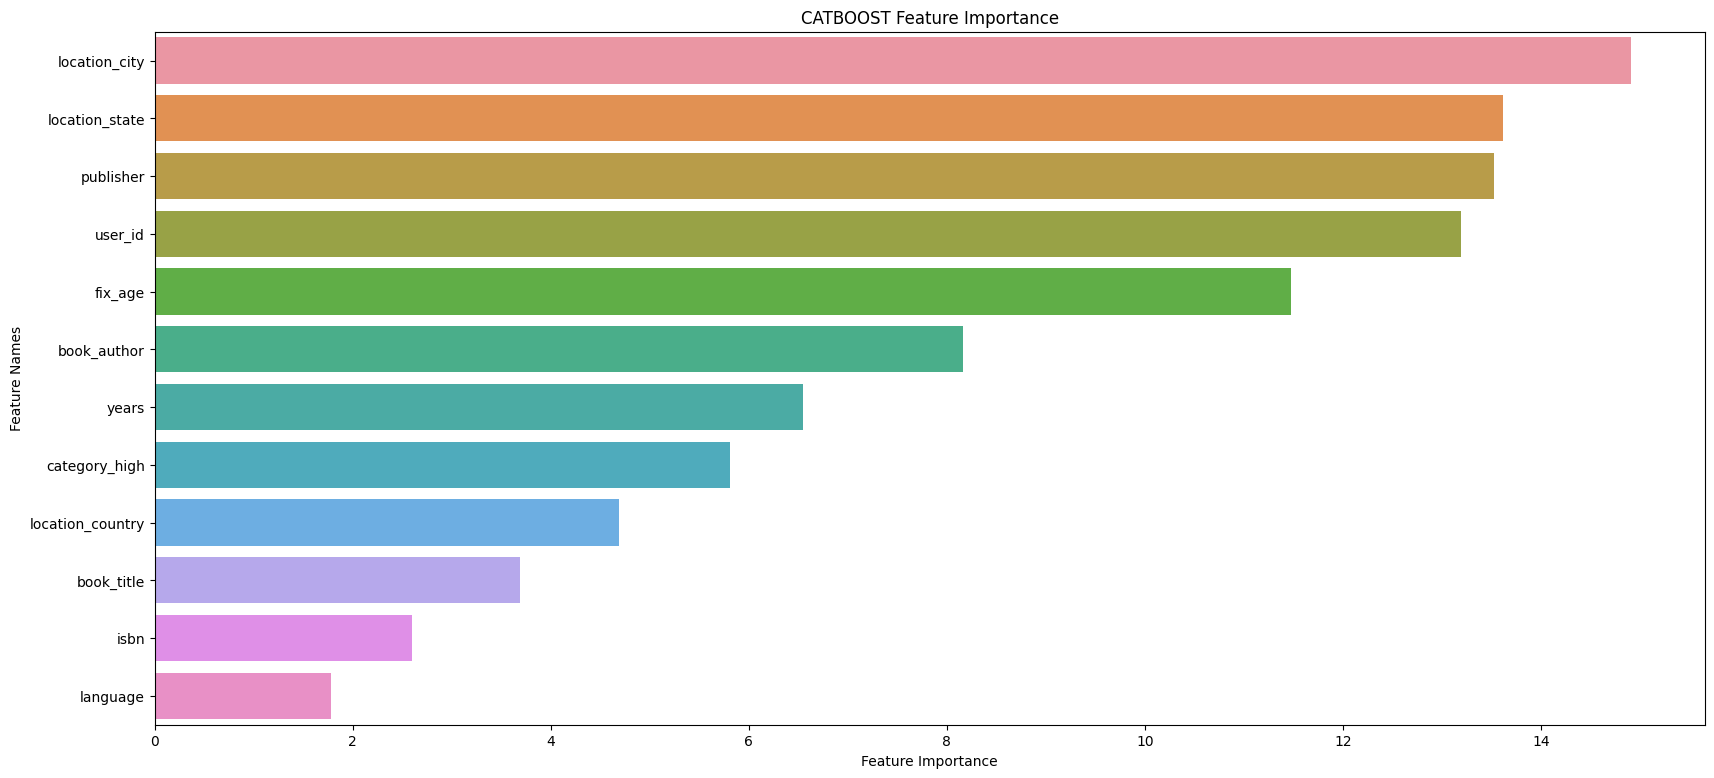

In [80]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')